Calculate the detsys errors for nue and numu. All detsys errors here are done together, as they are totally different to the nominal samples, and the varience from them calculated. This can then be added back in with the state errors in batch plot construction. 

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import sys
import localSettings as ls
import math
print(ls.main_path)
import load_data_run123
import plotter_alex
import importlib
importlib.reload(plotter_alex)
import uproot
import matplotlib.pylab as pylab
import numpy as np
import math
from sklearn.model_selection import train_test_split
import pickle
import xgboost as xgb
import nue_booster 
importlib.reload(nue_booster)
import awkward

/home/alex/NuMI/PELEE/


In [2]:
isRun3 = False
#combine these later as with the usual systematic variations
isCombined = True

ending = "Sept19"

isTruth = False

In [3]:
#https://docs.google.com/spreadsheets/d/1-4S0Ts2Lr6MkIo2FE9Mov6FeuZQ-q-qyNKQTLD7TApw/edit#gid=0
#Files are from here - New_run3 and New Run1 (intrinsic) and new_run1_highstats (overlay)

#These are high stats run 1
#Replace with numbers from extra stats calculation
detvar_run1_fhc = {
    "LYRayleigh": 7.60575E20, #Katrina 7.59732E20, #7.60573E20, 
    "LYDown": 7.43107E20, #Katrina 7.43109E20, 
    "SCE": 7.39879E20, #Katrina 7.39875E20, 
    "Recomb2": 7.59108E20, #Katrina 7.59105E20, 
    "WireModX": 7.64919E20, #Katrina 7.64918E20, 
    "WireModYZ": 7.53200E20, #Katrina 7.532E20, 
    "WireModThetaXZ": 7.64281E20, #Katrina 7.64282E20,
    "WireModThetaYZ_withSigmaSplines": 7.64541E20, #Katrina 7.64543E20, 
    "CV": 7.59735E20 #Katrina 7.59732E20
}

#These numbers are from "Pagina1" tan, the second ones from "Run1" tab
#Replace with numbers from Run1 tab
intrinsic_detvar_run1_fhc = {
    "LYRayleigh_intrinsic": 2.38081E+22, # Katrina 2.67655E22, #2.38081E22, 
    "LYDown_intrinsic": 2.24505E22, 
    "SCE_intrinsic": 2.39023E+22,  #Katrina 2.60685E22, #2.39023E22, 
    "Recomb2_intrinsic":  2.38193E+22,  #Katrina 2.60657E22, #2.38193E22, 
    "WireModX_intrinsic":  2.38318E+22,  #Katrina 2.66184E22, #2.38318E22, 
    "WireModYZ_intrinsic": 2.38416E+22,   #Katraina 2.62256E22, #2.38416E22,
    "WireModThetaXZ_intrinsic": 2.31518E+22, #Katrina 2.65175E22, #2.31518E22, 
    "WireModThetaYZ_withSigmaSplines_intrinsic": 2.31421E+22, #Katrina 2.62256E22, #2.31421E22, 
    "CV_intrinsic": 2.37261E+22 #Katrina 2.68294E22 #2.37261E22   
}

#from New_run3
detvar_run3_rhc = {
    "LYAttenuation": 3.31177E20, #checked
    "LYRayleigh":  3.15492E20, # 2.81E20, checked
    "LYDown": 3.23381E20, #checked 2.81E20, Katrina = 3.2338E20
    "SCE": 3.33283E20, #checked
    "Recomb2": 3.29538E20, #checked. Katrina = 3.29539E20
    "WireModX": 3.24286E20, #checked
    "WireModYZ": 3.36399E20, # checked
    "WireModThetaXZ": 3.20027E20, #checked
    "WireModThetaYZ_withSigmaSplines": 3.35762E20, #checked
    "CV": 2.87218E20 #checked. 2.72E20 Katrina = 2.87219E20
    
}

intrinsic_detvar_run3_rhc = {
    "LYAttenuation_intrinsic": 2.54177E+22, #2.54177E+22 - checked. Katrina - 2.5392E22
    "LYRayleigh_intrinsic": 2.53581E22,   #checked
    "LYDown_intrinsic": 2.53082E22, #checked
    "SCE_intrinsic": 2.54153E22,   #Checked
    "Recomb2_intrinsic": 2.54549E22,  #Checked
    "WireModX_intrinsic": 2.50092E22, #checked
    "WireModYZ_intrinsic": 2.54089E22,   #checked
    "WireModThetaXZ_intrinsic": 2.44365E22, #checked
    "WireModThetaYZ_withSigmaSplines_intrinsic":2.5992E22, #checked
    "CV_intrinsic": 2.5392E22   #Checked
    
}


In [4]:
if isRun3 == False and isCombined == False:
    standard_dict = detvar_run1_fhc
    intrinsic_dict = intrinsic_detvar_run1_fhc

    run = 'run1'
    detvar = detvar_run1_fhc
elif isRun3 == True and isCombined == False:
    standard_dict = detvar_run3_rhc
    intrinsic_dict = intrinsic_detvar_run3_rhc

    run = 'run3'
    detvar = detvar_run3_rhc
elif isCombined == True:
    standard_dict_run1 = detvar_run1_fhc
    intrinsic_dict_run1 = intrinsic_detvar_run1_fhc
    run_run1 = 'run1'
    detvar_run1 = detvar_run1_fhc
    standard_dict_run3 = detvar_run3_rhc
    intrinsic_dict_run3 = intrinsic_detvar_run3_rhc
    run_run3 = 'run3'
    detvar_run3 = detvar_run3_rhc

In [5]:
variables = [
    "nu_pdg", "ccnc",
    "true_nu_vtx_x", "true_nu_vtx_y" , "true_nu_vtx_z", 
    "swtrig_pre", "npion", "nproton", "npi0",
    "reco_nu_vtx_sce_x","reco_nu_vtx_sce_y","reco_nu_vtx_sce_z",
    "n_tracks_contained", 
    "shr_tkfit_dedx_Y",  
    "shrsubclusters0","shrsubclusters1","shrsubclusters2", # number of sub-clusters in shower
    "trkshrhitdist2",
    "n_showers_contained",
    "shr_score", "tksh_angle", 
    "trk_energy", 
    "tksh_distance", "trk_energy_tot",
    "shr_energy_tot_cali", "shr_energy_cali",
    "nslice", "elec_e", "proton_e",
    "contained_fraction", 
    "shrmoliereavg", "category",
    "ppfx_cv", "weightSplineTimesTune", "NeutrinoEnergy2", "shr_energy_cali", "nu_e"
]

In [6]:
input_path = "/media/alex/TOSHIBA EXT/detSys/"

In [7]:
if isCombined == False:
    print(detvar.keys())
elif isCombined == True:
    print(detvar_run1.keys())
    print(detvar_run3.keys())

dict_keys(['LYRayleigh', 'LYDown', 'SCE', 'Recomb2', 'WireModX', 'WireModYZ', 'WireModThetaXZ', 'WireModThetaYZ_withSigmaSplines', 'CV'])
dict_keys(['LYAttenuation', 'LYRayleigh', 'LYDown', 'SCE', 'Recomb2', 'WireModX', 'WireModYZ', 'WireModThetaXZ', 'WireModThetaYZ_withSigmaSplines', 'CV'])


In [8]:
fold = "nuselection"
tree = "NeutrinoSelectionFilter"

In [9]:
#For normalisation

if isRun3 == False and isCombined == False:
    beamon_pot = 2e+20
elif isRun3 == True and isCombined == False:
    beamon_pot = 5.014e+20
elif isCombined == True:
    beamon_pot_run1 = 2e+20
    beamon_pot_run3 = 5.014e+20

In [11]:
#xvar = "reco_e"
#bins = np.arange(0, 5.5, 0.5)
#x_label = "Reconstructed Energy [GeV]"

if isTruth == True:
    xvar = "true_nu_vtx_x" 
    x_label = "True X Position [cm]"
else:
    xvar = "reco_e"
    bins = np.arange(0, 5.5, 0.5)
    x_label = "Reconstructed Energy [GeV]"
    #xvar = "reco_nu_vtx_sce_x"
    #x_label = "Reconstructed X Position [cm]"
    
    
#bins = [0, 25, 50, 75, 100, 125, 150, 175, 200, 225]

xlow = bins[0]
xhigh = bins[-1]

In [12]:
reco_in_fv_query = "10<=reco_nu_vtx_sce_x<=246 and -106<=reco_nu_vtx_sce_y<=106 and 10<=reco_nu_vtx_sce_z<=1026"

BDT_PRE_QUERY = 'swtrig_pre==1 and nslice==1'
BDT_PRE_QUERY += ' and ' + reco_in_fv_query
BDT_PRE_QUERY +=' and contained_fraction>0.9'
BDT_PRE_QUERY += ' and n_showers_contained==1'
BDT_PRE_QUERY += ' and n_tracks_contained>0'
BDT_PRE_QUERY += ' and trk_energy>0.04' 
    
BDT_LOOSE_CUTS = BDT_PRE_QUERY
BDT_LOOSE_CUTS +=' and shr_score<0.3'
BDT_LOOSE_CUTS += ' and shrmoliereavg<15'
BDT_LOOSE_CUTS += ' and shr_tkfit_dedx_Y<7'
BDT_LOOSE_CUTS += ' and trkpid<0.35'
BDT_LOOSE_CUTS += ' and tksh_distance<12'

#################################################

NUE_SEL_QUERY = BDT_LOOSE_CUTS
#Katrina won't have these, and also will only work for one variable
#NUE_SEL_QUERY += ' and reco_e > 0.04 and reco_e < 5'
#NUE_SEL_QUERY += ' and true_e > 0.04 and true_e < 5'

if isRun3 == False and isCombined == False:
    NUE_SEL_QUERY += ' and BDT_score > 0.55'
elif isRun3 == True and isCombined == False:
    NUE_SEL_QUERY += ' and BDT_score > 0.575'
elif isCombined == True:
    NUE_SEL_QUERY_R1 = NUE_SEL_QUERY + ' and BDT_score > 0.55'
    NUE_SEL_QUERY_R3 = NUE_SEL_QUERY + ' and BDT_score > 0.55'

In [13]:
# load bdt model 
bdt_model = xgb.Booster({'nthread': 4})
bdt_model_r1 = xgb.Booster({'nthread': 4})
bdt_model_r3 = xgb.Booster({'nthread': 4})

if isRun3==False and isCombined == False:
    bdt_model.load_model('/home/alex/NuMI/bdt_FHC_may2022_subset.model')
elif isRun3==True and isCombined == False:
    bdt_model.load_model('/home/alex/NuMI/bdt_RHC_may2022_subset.model')
elif isCombined == True:
    bdt_model_r1.load_model('/home/alex/NuMI/bdt_FHC_may2022_subset.model')
    bdt_model_r3.load_model('/home/alex/NuMI/bdt_RHC_may2022_subset.model')
    
if isTruth == False:
    useBDT = True
elif isTruth == True:
    useBDT = False

In [14]:
training_parameters = [
    "shr_score", "shrmoliereavg", "trkpid",
    "n_showers_contained", "shr_tkfit_dedx_Y", "tksh_distance",
    "tksh_angle", "subcluster", "trkshrhitdist2"]

In [15]:
if isCombined == False:
    detvar_dict = {}
elif isCombined == True:
    detvar_dict_run1 = {}
    detvar_dict_run3 = {}

In [16]:
in_AV_query = "-1.55<=true_nu_vtx_x<=254.8 and -116.5<=true_nu_vtx_y<=116.5 and 0<=true_nu_vtx_z<=1036.8"
nueCC_query = 'abs(nu_pdg)==12 and ccnc==0 and '+in_AV_query

In [16]:
if isCombined == False:
    for variation in detvar.keys(): 

        print("Plotting", variation)

        standard_input_file = input_path + "standard_overlay/neutrinoselection_filt_"+run+"_overlay_"+variation+".root"
        intrinsic_input_file = input_path + "intrinsic/neutrinoselection_filt_"+run+"_overlay_"+variation+"_intrinsic.root"

        f_standard = uproot.open(standard_input_file)[fold][tree]
        f_intrinsic = uproot.open(intrinsic_input_file)[fold][tree]

        uproot_v = [f_standard, f_intrinsic]

        df_standard = f_standard.pandas.df(variables, flatten=False)
        df_intrinsic = f_intrinsic.pandas.df(variables, flatten=False)

        print("All good to here.")

        #INTERCEPT = 0.0
        #SLOPE = 0.83

        for i, df in enumerate([df_standard, df_intrinsic]):

            up = uproot_v[i]
            trk_llr_pid_v = up.array('trk_llr_pid_score_v')
            trk_id = up.array('trk_id')-1 
            trk_llr_pid_v_sel = awkward.fromiter([pidv[tid] if tid<len(pidv) else 9999. for pidv,tid in zip(trk_llr_pid_v,trk_id)])
            df['trkpid'] = trk_llr_pid_v_sel
            df['subcluster'] = df['shrsubclusters0'] + df['shrsubclusters1'] + df['shrsubclusters2']
            #df["reco_e"] = (df["shr_energy_tot_cali"] + INTERCEPT) / SLOPE + df["trk_energy_tot"]
            #df["true_e"] = (df["elec_e"] + INTERCEPT) / SLOPE + df["proton_e"]
            #df['NeutrinoEnergy2_GeV'] = df['NeutrinoEnergy2']/1000

            df.loc[ df['weightSplineTimesTune'] <= 0, 'weightSplineTimesTune' ] = 1.
            df.loc[ df['weightSplineTimesTune'] == np.inf, 'weightSplineTimesTune' ] = 1.
            df.loc[ df['weightSplineTimesTune'] > 100, 'weightSplineTimesTune' ] = 1.
            df.loc[ np.isnan(df['weightSplineTimesTune']) == True, 'weightSplineTimesTune' ] = 1.

            # bool for is signal vs is not signal 
            #df['is_signal'] = np.where((df.true_e>0.04) & (df.true_e <5) & (df.reco_e>0.04) & (df.reco_e <5) & (df.category==11)
            #                         & (df.nu_pdg==12) & (df.ccnc==0) & (df.nproton>0) & (df.npion==0) & (df.npi0==0)
            #                         & (-1.55 <= df.true_nu_vtx_x) & (df.true_nu_vtx_x <= 254.8)
            #                         & (-116.5 <= df.true_nu_vtx_y) & (df.true_nu_vtx_y <= 116.5)
            #                         & (0 <= df.true_nu_vtx_z) & (df.true_nu_vtx_z <= 1036.8), True, False)
            df['is_signal'] = np.where( (df.swtrig_pre==1)
                                     & (df.nu_pdg==12) & (df.ccnc==0) & (df.nproton>0) & (df.npion==0) & (df.npi0==0)
                                     & (10 <= df.true_nu_vtx_x) & (df.true_nu_vtx_x <= 246)
                                     & (-106 <= df.true_nu_vtx_y) & (df.true_nu_vtx_y <= 106)
                                     & (10 <= df.true_nu_vtx_z) & (df.true_nu_vtx_z <= 1026), True, False)

            print('is_signal check:', len(df) == len(df.query('is_signal==True')) + len(df.query('is_signal==False')))

        # APPLY SW TRIGGER
        df_standard = df_standard.query('swtrig_pre==1')
        df_intrinsic = df_intrinsic.query('swtrig_pre==1')

        # POT SCALING
        df_standard['pot_scale'] = beamon_pot/standard_dict.get(variation) #standard_dict.get('CV')/standard_dict.get(variation)       
        df_standard['pot_scale_dirt'] = (beamon_pot/standard_dict.get(variation)) * 0.75 #standard_dict.get('CV')/standard_dict.get(variation) by dirt scale      
        df_intrinsic['pot_scale'] = beamon_pot/intrinsic_dict.get(variation+'_intrinsic') #intrinsic_dict.get('CV_intrinsic')/intrinsic_dict.get(variation+'_intrinsic') 

        # remove nue CC events 
        print("# nueCC in AV in standard overlay det. sys. sample = "+str(len(df_standard.query(nueCC_query))))
        len1 = len(df_standard)

        idx = df_standard.query(nueCC_query).index
        df_standard.drop(idx, inplace=True)
        len2 = len(df_standard) 

        print("# of nueCC in AV removed = "+str(len1-len2)) # should be same as above

        if useBDT: 

            print('Using BDT')

            df_bdt_standard = df_standard.copy()
            df_bdt_intrinsic = df_intrinsic.copy()

            # clean datasets 
            for column in training_parameters:
                df_bdt_standard.loc[(df_bdt_standard[column] < -1.0e37) | (df_bdt_standard[column] > 1.0e37), column] = np.nan
                df_bdt_intrinsic.loc[(df_bdt_intrinsic[column] < -1.0e37) | (df_bdt_intrinsic[column] > 1.0e37), column] = np.nan

            # apply BDT model
            df_test_standard = xgb.DMatrix(data=df_bdt_standard[training_parameters])
            preds_standard = bdt_model.predict(df_test_standard)
            df_bdt_standard['BDT_score'] = preds_standard

            df_test_intrinsic = xgb.DMatrix(data=df_bdt_intrinsic[training_parameters])
            preds_intrinsic = bdt_model.predict(df_test_intrinsic)
            df_bdt_intrinsic['BDT_score'] = preds_intrinsic

            df_standard_sel = df_bdt_standard.query(NUE_SEL_QUERY).copy()
            df_intrinsic_sel = df_bdt_intrinsic.query(NUE_SEL_QUERY).copy()

        else: 
            df_standard_sel = df_standard.query(NUE_SEL_QUERY).copy()
            df_intrinsic_sel = df_intrinsic.query(NUE_SEL_QUERY).copy()

        standard_counts = plt.hist(df_standard_sel[xvar], bins, range=[bins[0], bins[-1]], 
                weights=df_standard_sel['ppfx_cv']*df_standard_sel['weightSplineTimesTune']*df_standard_sel['pot_scale'])[0]
        plt.close()

        print("non-nueCC events = ", sum(standard_counts))

        dirt_counts = plt.hist(df_standard_sel[xvar], bins, range=[bins[0], bins[-1]], 
                weights=df_standard_sel['ppfx_cv']*df_standard_sel['weightSplineTimesTune']*df_standard_sel['pot_scale_dirt'])[0]
        plt.close()

        print("dirt events = ", sum(dirt_counts))

        intrinsic_counts = plt.hist(df_intrinsic_sel[xvar], bins, range=[bins[0], bins[-1]], 
                weights=df_intrinsic_sel['ppfx_cv']*df_intrinsic_sel['weightSplineTimesTune']*df_intrinsic_sel['pot_scale'])[0]
        plt.close()


        print("nue CC events = ", sum(intrinsic_counts))


        # store counts in a dictionary 
        detvar_dict[variation] = list(standard_counts)
        detvar_dict[variation+'_intrinsic'] = list(intrinsic_counts)
        detvar_dict[variation+'_dirt'] = list(dirt_counts)

In [18]:
import pandas as pandas
import time
s = time.time()

useBDT = True

if isCombined == True:
    for variation in detvar_run1.keys(): 

        print("Plotting", variation)

        standard_input_file = input_path + "standard_overlay/neutrinoselection_filt_"+run_run1+"_overlay_"+variation+".root"
        intrinsic_input_file = input_path + "intrinsic/neutrinoselection_filt_"+run_run1+"_overlay_"+variation+"_intrinsic.root"

        f_standard = uproot.open(standard_input_file)[fold][tree]
        f_intrinsic = uproot.open(intrinsic_input_file)[fold][tree]

        uproot_v = [f_standard, f_intrinsic]

        df_standard = f_standard.pandas.df(variables, flatten=False)
        df_intrinsic = f_intrinsic.pandas.df(variables, flatten=False)

        print("All good to here.")

        INTERCEPT = 0.0
        SLOPE = 0.83



        for i, df in enumerate([df_standard, df_intrinsic]):

            up = uproot_v[i]
            trk_llr_pid_v = up.array('trk_llr_pid_score_v')
            trk_id = up.array('trk_id')-1 
            trk_llr_pid_v_sel = awkward.fromiter([pidv[tid] if tid<len(pidv) else 9999. for pidv,tid in zip(trk_llr_pid_v,trk_id)])
            df['trkpid'] = trk_llr_pid_v_sel
            df['subcluster'] = df['shrsubclusters0'] + df['shrsubclusters1'] + df['shrsubclusters2']
            df["reco_e"] = (df["shr_energy_tot_cali"] + INTERCEPT) / SLOPE + df["trk_energy_tot"]
            df["true_e"] = (df["elec_e"] + INTERCEPT) / SLOPE + df["proton_e"]

            df.loc[ df['weightSplineTimesTune'] <= 0, 'weightSplineTimesTune' ] = 1.
            df.loc[ df['weightSplineTimesTune'] == np.inf, 'weightSplineTimesTune' ] = 1.
            df.loc[ df['weightSplineTimesTune'] > 100, 'weightSplineTimesTune' ] = 1.
            df.loc[ np.isnan(df['weightSplineTimesTune']) == True, 'weightSplineTimesTune' ] = 1.

            # bool for is signal vs is not signal 
            df['is_signal'] = np.where( (df.swtrig_pre==1) 
                                 & (df.nu_pdg==12) & (df.ccnc==0) & (df.nproton>0) & (df.npion==0) & (df.npi0==0)
                                 & (10 <= df.true_nu_vtx_x) & (df.true_nu_vtx_x <= 246)
                                 & (-106 <= df.true_nu_vtx_y) & (df.true_nu_vtx_y <= 106)
                                 & (10 <= df.true_nu_vtx_z) & (df.true_nu_vtx_z <= 1026), True, False)
    

            print('is_signal check inside:', len(df) == len(df.query('is_signal==True')) + len(df.query('is_signal==False')))
            print(len(df.query('is_signal==True')))
            print(len(df.query('is_signal==False')))  
        
        
        # APPLY SW TRIGGER
        if isTruth == False:
            df_standard = df_standard.query('swtrig_pre==1')
            df_intrinsic = df_intrinsic.query('swtrig_pre==1')

        # POT SCALING
        #df_standard['pot_scale'] = beamon_pot_run1/standard_dict_run1.get(variation) #standard_dict.get('CV')/standard_dict.get(variation)       
        #df_standard['pot_scale_dirt'] = (beamon_pot_run1/standard_dict_run1.get(variation)) * 0.75 #standard_dict.get('CV')/standard_dict.get(variation) by dirt scale      
        #df_intrinsic['pot_scale'] = beamon_pot_run1/intrinsic_dict_run1.get(variation+'_intrinsic') #intrinsic_dict.get('CV_intrinsic')/intrinsic_dict.get(variation+'_intrinsic') 
        df_standard['pot_scale'] = standard_dict_run1.get('CV')/standard_dict_run1.get(variation)       
        df_standard['pot_scale_dirt'] = standard_dict_run1.get('CV')/standard_dict_run1.get(variation) * 0.75     
        df_intrinsic['pot_scale'] = intrinsic_dict_run1.get('CV_intrinsic')/intrinsic_dict_run1.get(variation+'_intrinsic') 

        # remove nue CC events 
        print("# nueCC in AV in standard overlay det. sys. sample = "+str(len(df_standard.query(nueCC_query))))
        len1 = len(df_standard)

        idx = df_standard.query(nueCC_query).index
        df_standard.drop(idx, inplace=True)
        len2 = len(df_standard) 

        print("# of nueCC in AV removed = "+str(len1-len2)) # should be same as above

        
        if useBDT: 
            
            print('Using BDT')

            df_bdt_standard = df_standard.copy()
            df_bdt_intrinsic = df_intrinsic.copy()
        
            # clean datasets 
            for column in training_parameters:
                df_bdt_standard.loc[(df_bdt_standard[column] < -1.0e37) | (df_bdt_standard[column] > 1.0e37), column] = np.nan
                df_bdt_intrinsic.loc[(df_bdt_intrinsic[column] < -1.0e37) | (df_bdt_intrinsic[column] > 1.0e37), column] = np.nan

            # apply BDT model
            df_test_standard = xgb.DMatrix(data=df_bdt_standard[training_parameters])
            preds_standard = bdt_model_r1.predict(df_test_standard)
            df_bdt_standard['BDT_score'] = preds_standard

            df_test_intrinsic = xgb.DMatrix(data=df_bdt_intrinsic[training_parameters])
            preds_intrinsic = bdt_model_r1.predict(df_test_intrinsic)
            df_bdt_intrinsic['BDT_score'] = preds_intrinsic
            
            
            if isTruth==False:
                df_standard_sel_run1 = df_bdt_standard.query(NUE_SEL_QUERY_R1).copy()
                df_intrinsic_sel_run1 = df_bdt_intrinsic.query(NUE_SEL_QUERY_R1).copy()
            elif isTruth==True:
                df_standard_sel_run1 = df_bdt_standard.query('is_signal==True').copy()
                df_intrinsic_sel_run1 = df_bdt_intrinsic.query('is_signal==True').copy()
        else: 
            if isTruth==False:
                df_standard_sel_run1 = df_standard.query(NUE_SEL_QUERY_R1).copy()
                df_intrinsic_sel_run1 = df_intrinsic.query(NUE_SEL_QUERY_R1).copy()
            elif isTruth==True:
                df_standard_sel_run1 = df_standard.query('is_signal==True').copy()
                df_intrinsic_sel_run1 = df_intrinsic.query('is_signal==True').copy()
                


        standard_counts = plt.hist(df_standard_sel_run1[xvar], bins, range=[bins[0], bins[-1]], 
                weights=df_standard_sel_run1['ppfx_cv']*df_standard_sel_run1['weightSplineTimesTune']*df_standard_sel_run1['pot_scale'])[0]
        plt.close()

        print("non-nueCC events = ", sum(standard_counts))

        dirt_counts = plt.hist(df_standard_sel_run1[xvar], bins, range=[bins[0], bins[-1]], 
                weights=df_standard_sel_run1['ppfx_cv']*df_standard_sel_run1['weightSplineTimesTune']*df_standard_sel_run1['pot_scale_dirt'])[0]
        plt.close()

        print("dirt events = ", sum(dirt_counts))

        intrinsic_counts = plt.hist(df_intrinsic_sel_run1[xvar], bins, range=[bins[0], bins[-1]], 
                weights=df_intrinsic_sel_run1['ppfx_cv']*df_intrinsic_sel_run1['weightSplineTimesTune']*df_intrinsic_sel_run1['pot_scale'])[0]
        plt.close()


        print("nue CC events = ", sum(intrinsic_counts))


        # store counts in a dictionary 
        detvar_dict_run1[variation] = list(standard_counts)
        detvar_dict_run1[variation+'_intrinsic'] = list(intrinsic_counts)
        detvar_dict_run1[variation+'_dirt'] = list(dirt_counts)
        
    ########################################################################
    for variation in detvar_run3.keys(): 

        print("Plotting", variation)

        standard_input_file = input_path + "standard_overlay/neutrinoselection_filt_"+run_run3+"_overlay_"+variation+".root"
        intrinsic_input_file = input_path + "intrinsic/neutrinoselection_filt_"+run_run3+"_overlay_"+variation+"_intrinsic.root"

        f_standard = uproot.open(standard_input_file)[fold][tree]
        f_intrinsic = uproot.open(intrinsic_input_file)[fold][tree]

        uproot_v = [f_standard, f_intrinsic]

        df_standard = f_standard.pandas.df(variables, flatten=False)
        df_intrinsic = f_intrinsic.pandas.df(variables, flatten=False)

        print("All good to here.")

        #INTERCEPT = 0.0
        #SLOPE = 0.83



        for i, df in enumerate([df_standard, df_intrinsic]):

            up = uproot_v[i]
            trk_llr_pid_v = up.array('trk_llr_pid_score_v')
            trk_id = up.array('trk_id')-1 
            trk_llr_pid_v_sel = awkward.fromiter([pidv[tid] if tid<len(pidv) else 9999. for pidv,tid in zip(trk_llr_pid_v,trk_id)])
            df['trkpid'] = trk_llr_pid_v_sel
            df['subcluster'] = df['shrsubclusters0'] + df['shrsubclusters1'] + df['shrsubclusters2']
            df["reco_e"] = (df["shr_energy_tot_cali"] + INTERCEPT) / SLOPE + df["trk_energy_tot"]
            df["true_e"] = (df["elec_e"] + INTERCEPT) / SLOPE + df["proton_e"]

            df.loc[ df['weightSplineTimesTune'] <= 0, 'weightSplineTimesTune' ] = 1.
            df.loc[ df['weightSplineTimesTune'] == np.inf, 'weightSplineTimesTune' ] = 1.
            df.loc[ df['weightSplineTimesTune'] > 100, 'weightSplineTimesTune' ] = 1.
            df.loc[ np.isnan(df['weightSplineTimesTune']) == True, 'weightSplineTimesTune' ] = 1.

            # bool for is signal vs is not signal 
            df['is_signal'] = np.where( (df.swtrig_pre==1) 
                                 & (df.nu_pdg==12) & (df.ccnc==0) & (df.nproton>0) & (df.npion==0) & (df.npi0==0)
                                 & (10 <= df.true_nu_vtx_x) & (df.true_nu_vtx_x <= 246)
                                 & (-106 <= df.true_nu_vtx_y) & (df.true_nu_vtx_y <= 106)
                                 & (10 <= df.true_nu_vtx_z) & (df.true_nu_vtx_z <= 1026), True, False)
    

            print('is_signal check:', len(df) == len(df.query('is_signal==True')) + len(df.query('is_signal==False')))
            print(len(df.query('is_signal==True')))
            print(len(df.query('is_signal==False')))
            
        # APPLY SW TRIGGER
        if isTruth == False:
            df_standard = df_standard.query('swtrig_pre==1')
            df_intrinsic = df_intrinsic.query('swtrig_pre==1')

        # POT SCALING
        #df_standard['pot_scale'] = beamon_pot_run3/standard_dict_run3.get(variation) #standard_dict.get('CV')/standard_dict.get(variation)       
        #df_standard['pot_scale_dirt'] = (beamon_pot_run3/standard_dict_run3.get(variation)) * 0.75 #standard_dict.get('CV')/standard_dict.get(variation) by dirt scale      
        #df_intrinsic['pot_scale'] = beamon_pot_run3/intrinsic_dict_run3.get(variation+'_intrinsic') #intrinsic_dict.get('CV_intrinsic')/intrinsic_dict.get(variation+'_intrinsic') 
        df_standard['pot_scale'] = standard_dict_run3.get('CV')/standard_dict_run3.get(variation)       
        df_standard['pot_scale_dirt'] = standard_dict_run3.get('CV')/standard_dict_run3.get(variation)*0.75     
        df_intrinsic['pot_scale'] = intrinsic_dict_run3.get('CV_intrinsic')/intrinsic_dict_run3.get(variation+'_intrinsic') 

        # remove nue CC events 
        print("# nueCC in AV in standard overlay det. sys. sample = "+str(len(df_standard.query(nueCC_query))))
        len1 = len(df_standard)

        idx = df_standard.query(nueCC_query).index
        df_standard.drop(idx, inplace=True)
        len2 = len(df_standard) 

        print("# of nueCC in AV removed = "+str(len1-len2)) # should be same as above
        
        if useBDT: 
            
            print('Using BDT')

            df_bdt_standard = df_standard.copy()
            df_bdt_intrinsic = df_intrinsic.copy()

            # clean datasets 
            for column in training_parameters:
                df_bdt_standard.loc[(df_bdt_standard[column] < -1.0e37) | (df_bdt_standard[column] > 1.0e37), column] = np.nan
                df_bdt_intrinsic.loc[(df_bdt_intrinsic[column] < -1.0e37) | (df_bdt_intrinsic[column] > 1.0e37), column] = np.nan

            # apply BDT model
            df_test_standard = xgb.DMatrix(data=df_bdt_standard[training_parameters])
            preds_standard = bdt_model_r3.predict(df_test_standard)
            df_bdt_standard['BDT_score'] = preds_standard

            df_test_intrinsic = xgb.DMatrix(data=df_bdt_intrinsic[training_parameters])
            preds_intrinsic = bdt_model_r3.predict(df_test_intrinsic)
            df_bdt_intrinsic['BDT_score'] = preds_intrinsic
            

            if isTruth==False:
                df_standard_sel_run3 = df_bdt_standard.query(NUE_SEL_QUERY_R3).copy()
                df_intrinsic_sel_run3 = df_bdt_intrinsic.query(NUE_SEL_QUERY_R3).copy()
            elif isTruth==True:
                df_standard_sel_run3 = df_bdt_standard.query('is_signal==True').copy()
                df_intrinsic_sel_run3 = df_bdt_intrinsic.query('is_signal==True').copy()
        else: 
            if isTruth==False:
                df_standard_sel_run3 = df_standard.query(NUE_SEL_QUERY_R3).copy()
                df_intrinsic_sel_run3 = df_intrinsic.query(NUE_SEL_QUERY_R3).copy()
            elif isTruth==True:
                df_standard_sel_run3 = df_standard.query('is_signal==True').copy()
                df_intrinsic_sel_run3 = df_intrinsic.query('is_signal==True').copy()
                

        standard_counts = plt.hist(df_standard_sel_run3[xvar], bins, range=[bins[0], bins[-1]], 
                weights=df_standard_sel_run3['ppfx_cv']*df_standard_sel_run3['weightSplineTimesTune']*df_standard_sel_run3['pot_scale'])[0]
        plt.close()

        print("non-nueCC events = ", sum(standard_counts))

        dirt_counts = plt.hist(df_standard_sel_run3[xvar], bins, range=[bins[0], bins[-1]], 
                weights=df_standard_sel_run3['ppfx_cv']*df_standard_sel_run3['weightSplineTimesTune']*df_standard_sel_run3['pot_scale_dirt'])[0]
        plt.close()

        print("dirt events = ", sum(dirt_counts))

        intrinsic_counts = plt.hist(df_intrinsic_sel_run3[xvar], bins, range=[bins[0], bins[-1]], 
                weights=df_intrinsic_sel_run3['ppfx_cv']*df_intrinsic_sel_run3['weightSplineTimesTune']*df_intrinsic_sel_run3['pot_scale'])[0]
        plt.close()


        print("nue CC events = ", sum(intrinsic_counts))


        # store counts in a dictionary 
        detvar_dict_run3[variation] = list(standard_counts)
        detvar_dict_run3[variation+'_intrinsic'] = list(intrinsic_counts)
        detvar_dict_run3[variation+'_dirt'] = list(dirt_counts)
    
    
#just prints out the time this cell takes
s2 = time.time()
print ("time to run: ",s2-s)
#Approx 22 Mins

Plotting LYRayleigh
All good to here.
is_signal check inside: True
1394
296771
is_signal check inside: True
47036
80675
# nueCC in AV in standard overlay det. sys. sample = 3953
# of nueCC in AV removed = 3953
Using BDT


/tmp/ipykernel_11859/827684793.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_intrinsic['pot_scale'] = intrinsic_dict_run1.get('CV_intrinsic')/intrinsic_dict_run1.get(variation+'_intrinsic')


non-nueCC events =  60.60186890391963
dirt events =  45.45140167793973
nue CC events =  7439.029461434887
Plotting LYDown
All good to here.
is_signal check inside: True
1360
289895
is_signal check inside: True
44346
76067
# nueCC in AV in standard overlay det. sys. sample = 3849
# of nueCC in AV removed = 3849
Using BDT
non-nueCC events =  60.360681469312865
dirt events =  45.27051110198462
nue CC events =  7446.25272667332
Plotting SCE
All good to here.
is_signal check inside: True
1371
288482
is_signal check inside: True
47248
80990
# nueCC in AV in standard overlay det. sys. sample = 3862
# of nueCC in AV removed = 3862
Using BDT
non-nueCC events =  45.02607698444457
dirt events =  33.769557738333425
nue CC events =  7401.3331178414255
Plotting Recomb2
All good to here.
is_signal check inside: True
1397
296249
is_signal check inside: True
47095
80704
# nueCC in AV in standard overlay det. sys. sample = 3940
# of nueCC in AV removed = 3940
Using BDT
non-nueCC events =  50.86641281446

/tmp/ipykernel_11859/827684793.py:208: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_intrinsic['pot_scale'] = intrinsic_dict_run3.get('CV_intrinsic')/intrinsic_dict_run3.get(variation+'_intrinsic')


non-nueCC events =  26.94246037669807
dirt events =  20.206845282523556
nue CC events =  6585.350142819755
Plotting LYRayleigh
All good to here.
is_signal check: True
504
118190
is_signal check: True
40942
83572
# nueCC in AV in standard overlay det. sys. sample = 1541
# of nueCC in AV removed = 1541
Using BDT
non-nueCC events =  26.220457551442443
dirt events =  19.665343163581827
nue CC events =  6558.302207654504
Plotting LYDown
All good to here.
is_signal check: True
520
121150
is_signal check: True
40825
83445
# nueCC in AV in standard overlay det. sys. sample = 1579
# of nueCC in AV removed = 1579
Using BDT
non-nueCC events =  26.88823005691639
dirt events =  20.166172542687303
nue CC events =  6575.404027416394
Plotting SCE
All good to here.
is_signal check: True
527
124833
is_signal check: True
41030
83734
# nueCC in AV in standard overlay det. sys. sample = 1616
# of nueCC in AV removed = 1616
Using BDT
non-nueCC events =  25.141819989637458
dirt events =  18.856364992228094
n

In [19]:
## CV background event rate
if isCombined == False:
    x1 = plt.hist(df_standard_sel.query('is_signal==False')[xvar], bins, range=[bins[0], bins[-1]], 
                weights=df_standard_sel.query('is_signal==False')['ppfx_cv']*df_standard_sel.query('is_signal==False')['weightSplineTimesTune']*df_standard_sel.query('is_signal==False')['pot_scale'])[0]

    plt.close()

    x3 = plt.hist(df_standard_sel.query('is_signal==False')[xvar], bins, range=[bins[0], bins[-1]], 
                weights=df_standard_sel.query('is_signal==False')['ppfx_cv']*df_standard_sel.query('is_signal==False')['weightSplineTimesTune']*df_standard_sel.query('is_signal==False')['pot_scale_dirt'])[0]

    plt.close()

    x2 = plt.hist(df_intrinsic_sel.query('is_signal==False')[xvar], bins, range=[bins[0], bins[-1]], 
                weights=df_intrinsic_sel.query('is_signal==False')['ppfx_cv']*df_intrinsic_sel.query('is_signal==False')['weightSplineTimesTune']*df_intrinsic_sel.query('is_signal==False')['pot_scale'])[0]
    #x2 = plt.hist(df_intrinsic_sel[xvar], bins, range=[bins[0], bins[-1]], 
    #            weights=df_intrinsic_sel['ppfx_cv']*df_intrinsic_sel['weightSplineTimesTune']*df_intrinsic_sel['pot_scale'])[0]

    plt.close()
elif isCombined == True:
    x1_run1 = plt.hist(df_standard_sel_run1.query('is_signal==False')[xvar], bins, range=[bins[0], bins[-1]], 
                weights=df_standard_sel_run1.query('is_signal==False')['ppfx_cv']*df_standard_sel_run1.query('is_signal==False')['weightSplineTimesTune']*df_standard_sel_run1.query('is_signal==False')['pot_scale'])[0]

    plt.close()

    x3_run1 = plt.hist(df_standard_sel_run1.query('is_signal==False')[xvar], bins, range=[bins[0], bins[-1]], 
                weights=df_standard_sel_run1.query('is_signal==False')['ppfx_cv']*df_standard_sel_run1.query('is_signal==False')['weightSplineTimesTune']*df_standard_sel_run1.query('is_signal==False')['pot_scale_dirt'])[0]

    plt.close()

    x2_run1 = plt.hist(df_intrinsic_sel_run1.query('is_signal==False')[xvar], bins, range=[bins[0], bins[-1]], 
                weights=df_intrinsic_sel_run1.query('is_signal==False')['ppfx_cv']*df_intrinsic_sel_run1.query('is_signal==False')['weightSplineTimesTune']*df_intrinsic_sel_run1.query('is_signal==False')['pot_scale'])[0]
    #x2_run1 = plt.hist(df_intrinsic_sel_run1[xvar], bins, range=[bins[0], bins[-1]], 
    #            weights=df_intrinsic_sel_run1['ppfx_cv']*df_intrinsic_sel_run1['weightSplineTimesTune']*df_intrinsic_sel_run1['pot_scale'])[0]

    plt.close()
    
    x1_run3 = plt.hist(df_standard_sel_run3.query('is_signal==False')[xvar], bins, range=[bins[0], bins[-1]], 
                weights=df_standard_sel_run3.query('is_signal==False')['ppfx_cv']*df_standard_sel_run3.query('is_signal==False')['weightSplineTimesTune']*df_standard_sel_run3.query('is_signal==False')['pot_scale'])[0]

    plt.close()

    x3_run3 = plt.hist(df_standard_sel_run3.query('is_signal==False')[xvar], bins, range=[bins[0], bins[-1]], 
                weights=df_standard_sel_run3.query('is_signal==False')['ppfx_cv']*df_standard_sel_run3.query('is_signal==False')['weightSplineTimesTune']*df_standard_sel_run3.query('is_signal==False')['pot_scale_dirt'])[0]

    plt.close()

    x2_run3 = plt.hist(df_intrinsic_sel_run3.query('is_signal==False')[xvar], bins, range=[bins[0], bins[-1]], 
                weights=df_intrinsic_sel_run3.query('is_signal==False')['ppfx_cv']*df_intrinsic_sel_run3.query('is_signal==False')['weightSplineTimesTune']*df_intrinsic_sel_run3.query('is_signal==False')['pot_scale'])[0]
    #x2_run3 = plt.hist(df_intrinsic_sel_run3[xvar], bins, range=[bins[0], bins[-1]], 
     #           weights=df_intrinsic_sel_run3['ppfx_cv']*df_intrinsic_sel_run3['weightSplineTimesTune']*df_intrinsic_sel_run3['pot_scale'])[0]

    plt.close()

In [20]:
print(x2_run3)

x2_run3b = plt.hist(df_intrinsic_sel_run3.query('is_signal==True')[xvar], bins, range=[bins[0], bins[-1]], 
                weights=df_intrinsic_sel_run3.query('is_signal==True')['ppfx_cv']*df_intrinsic_sel_run3.query('is_signal==True')['weightSplineTimesTune']*df_intrinsic_sel_run3.query('is_signal==True')['pot_scale'])[0]
plt.close()
print(x2_run3b)    

[114.99872021 503.38078606 322.21127177 139.19546433  61.27192479
  30.63195026  10.54870903   5.41687524   0.97504628   3.74834156]
[ 838.31862809 2596.91813712 1262.47603315  401.66577645  164.62117641
   74.55794653   37.5213857    12.27077802    8.75730443    3.20878732]


In [21]:
if isCombined == False:
    detvar_dict['cv_total_bkgd'] = x1+x2+x3
elif isCombined == True:
    detvar_dict_run1['cv_total_bkgd'] = list(x1_run1+x2_run1+x3_run1)
    detvar_dict_run3['cv_total_bkgd'] = list(x1_run3+x2_run3+x3_run3)
    detvar_dict_run1['cv_int_bkgd'] = list(x2_run1)
    detvar_dict_run3['cv_int_bkgd'] = list(x2_run3)

#print(x2)

In [21]:
detvar_dict_run1

{'LYRayleigh': [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
 'LYRayleigh_intrinsic': [28.541263463759144,
  46.56650633126163,
  45.7042135896659,
  46.31616578660572,
  46.24038089076785,
  47.42427004348053,
  46.657881005977856,
  44.93198067257197,
  45.72359334747483],
 'LYRayleigh_dirt': [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
 'LYDown': [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
 'LYDown_intrinsic': [28.470225587509006,
  46.62020374376792,
  45.7565195208019,
  46.45639377401183,
  46.151043960614345,
  47.48456044813307,
  46.856140183389414,
  45.36035602613805,
  45.8661692021098],
 'LYDown_dirt': [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
 'SCE': [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
 'SCE_intrinsic': [28.503015695827525,
  46.685875348086114,
  45.748166016920436,
  46.282073692574,
  46.30656848853289,
  47.473548788415826,
  46.717676514600214,
  44.87048214790826,
  45.74599359389737],
 'SCE_dirt': [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],

In [36]:
import csv

if isTruth == True:
    print("Truth")
    
    with open('nue_detsys_detvar_dict_cut_run1_Sept19.csv', 'w') as f:
        w = csv.DictWriter(f, detvar_dict_run1.keys())
        w.writeheader()
        w.writerow(detvar_dict_run1)


    with open('nue_detsys_detvar_dict_cut_run3_Sept19.csv', 'w') as f:
        w = csv.DictWriter(f, detvar_dict_run3.keys())
        w.writeheader()
        w.writerow(detvar_dict_run3)

In [22]:
x_err = [ round(abs(bins[x+1]-bins[x])/2, 3) for x in range(len(bins)-1) ]
bin_centers = []
for a in range(len(bins)-1): 
    bin_centers.append(round(bins[a] + (bins[a+1]-bins[a])/2, 3))

In [23]:

#if isCombined == False:
#    print(detvar_dict['cv_total_bkgd'])
#elif isCombined == True:
#    print(detvar_dict_run1['cv_total_bkgd'])
#    print(detvar_dict_run3['cv_total_bkgd'])

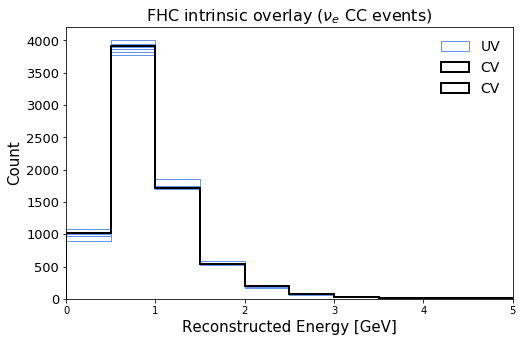

In [25]:
# nue CC variations - does not include LY Attentuation (RHC only)

n=0
fig = plt.figure(figsize=(8, 5)) 


for variation in detvar_run1_fhc.keys(): 
    
    if variation=='CV_intrinsic': 
        continue
        
    if n==0: 
        plt.hist(bin_centers, bins, histtype='step', weights=detvar_dict_run1[variation+"_intrinsic"], 
             linewidth=1, color='cornflowerblue', label='UV')
        
    else: 
        plt.hist(bin_centers, bins, histtype='step', weights=detvar_dict_run1[variation+"_intrinsic"],
             linewidth=1, color='cornflowerblue')
        
    n+=1

plt.hist(bin_centers, bins, histtype='step', 
                 weights=detvar_dict_run1['CV_intrinsic'], color='black', label='CV', linewidth=2)

current = (plt.hist(bin_centers, bins, histtype='step', 
                 weights=detvar_dict_run1['CV_intrinsic'], color='black', label='CV', linewidth=2)[0])

plt.title('FHC intrinsic overlay ($\\nu_{e}$ CC events)', fontsize=16)

plt.ylabel('Count' , fontsize=15) # 2.68294E22
plt.xlabel(x_label, fontsize=15)

#plt.xticks(x_ticks, fontsize=13)
plt.yticks(fontsize=13)

plt.legend(frameon=False, fontsize=14)

plt.xlim(xlow, xhigh)

plt.savefig("FHC_Nue_Detsys_NueCC.svg", bbox_inches='tight')
    
plt.show()

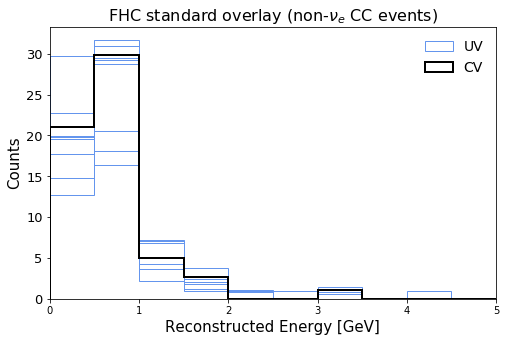

In [26]:
# nue CC variations - does not include LY Attentuation (RHC only)

n=0
fig = plt.figure(figsize=(8, 5)) 


for variation in detvar_run1_fhc.keys(): 
    
    if variation=='CV': 
        continue
        
    if n==0: 
        plt.hist(bin_centers, bins, histtype='step', weights=detvar_dict_run1[variation], 
             linewidth=1, color='cornflowerblue', label='UV')
        
    else: 
        plt.hist(bin_centers, bins, histtype='step', weights=detvar_dict_run1[variation],
             linewidth=1, color='cornflowerblue')
        
    n+=1

plt.hist(bin_centers, bins, histtype='step', 
                 weights=detvar_dict_run1['CV'], color='black', label='CV', linewidth=2)


plt.title('FHC standard overlay (non-$\\nu_{e}$ CC events)', fontsize=16)

plt.ylabel('Counts' , fontsize=15) # 7.59732E20+2.87219E20
plt.xlabel(x_label, fontsize=15)

#plt.xticks(x_ticks, fontsize=13)
plt.yticks(fontsize=13)

plt.legend(frameon=False, fontsize=14)

plt.xlim(xlow, xhigh)

plt.savefig("FHC_Nue_Detsys_NonNueCC.svg", bbox_inches='tight')
    
plt.show()

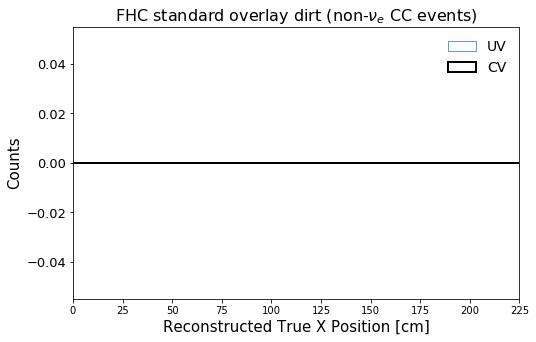

In [25]:
# nue CC dirt variations - does not include LY Attentuation (RHC only)

n=0
fig = plt.figure(figsize=(8, 5)) 


for variation in detvar_run1_fhc.keys(): 
    
    if variation=='CV': 
        continue
        
    if n==0: 
        plt.hist(bin_centers, bins, histtype='step', weights=detvar_dict_run1[variation+"_dirt"], 
             linewidth=1, color='cornflowerblue', label='UV')
        
    else: 
        plt.hist(bin_centers, bins, histtype='step', weights=detvar_dict_run1[variation+"_dirt"],
             linewidth=1, color='cornflowerblue')
        
    n+=1

plt.hist(bin_centers, bins, histtype='step', 
                 weights=detvar_dict_run1['CV_dirt'], color='black', label='CV', linewidth=2)


plt.title('FHC standard overlay dirt (non-$\\nu_{e}$ CC events)', fontsize=16)

plt.ylabel('Counts' , fontsize=15) # 7.59732E20+2.87219E20
plt.xlabel("Reconstructed "+x_label, fontsize=15)

#plt.xticks(x_ticks, fontsize=13)
plt.yticks(fontsize=13)

plt.legend(frameon=False, fontsize=14)

plt.xlim(xlow, xhigh)

    
plt.show()

In [42]:
#detvar_dict['CV_intrinsic']

In [26]:
def calcCov(var, bins, ncv_nu, ncv_total, uni_counts, plot=False, save=False, axis_label=None, pot=None, isrun3=False, xticks=None, xhigh=None): 
    
    # ncv nu is the neutrino event rate -- i.e. what gets varied in the systematics 
    # ncv total is the total event rate -- (MC + EXT or estimated signal)
    # when background subtracting these two are the same  
    
    # compute the cov matrix 
    cov = [ [0]*(len(bins)-1) for x in range(len(bins)-1) ]
    frac_cov = [ [0]*(len(bins)-1) for x in range(len(bins)-1) ]
    cor = [ [0]*(len(bins)-1) for x in range(len(bins)-1) ]
    
    N = len(uni_counts)
    print('number of universes = ', N)

    #####################################################
    
    for k in range(N): 
        
        uni = uni_counts[k]

        for i in range(len(bins)-1): 

            cvi = ncv_nu[i]
            uvi = uni[i]


            for j in range(len(bins)-1): 
                
                cvj = ncv_nu[j]
                uvj = uni[j]
        
                c = ((uvi - cvi)*(uvj - cvj)) / N

                cov[i][j] += c
                
                
                if ncv_total[i]*ncv_total[j] != 0: 
                    frac_cov[i][j] += c/(ncv_total[i]*ncv_total[j])
                    #frac_cov[i][j] = c/(ncv_total[i]*ncv_total[j])
            
    #####################################################
    
    if plot: 
        fig = plt.figure(figsize=(10, 6))
        
        plt.pcolor(bins, bins, cov, cmap='OrRd', edgecolors='k')
            
        cbar = plt.colorbar()
        cbar.ax.tick_params(labelsize=14)
        if pot: 
            cbar.set_label(label="$\\nu^{2}$ / "+pot+"$^{2}$", fontsize=15)
        
        plt.xticks(xticks, fontsize=13)
        plt.yticks(xticks,fontsize=13)
        
        if xhigh: 
            plt.xlim(bins[0], xhigh)
            plt.ylim(bins[0], xhigh)
            
        else: 
            plt.xlim(bins[0], bins[-1])
            plt.ylim(bins[0], bins[-1])

        if axis_label is not None: 
            plt.xlabel(axis_label, fontsize=15)
            plt.ylabel(axis_label, fontsize=15)
        else: 
            plt.xlabel(var, fontsize=15)
            plt.ylabel(var, fontsize=15)

        plt.title('Covariance Matrix', fontsize=16)
        
        if save: 
            plt.savefig(save+var+"_cov.pdf", transparent=True, bbox_inches='tight') 
            print('saving to: '+save)
        plt.show()
        
        ##################################
        # fractional covariance 
        fig = plt.figure(figsize=(10, 6))
        
        plt.pcolor(bins, bins, frac_cov, cmap='OrRd', edgecolors='k')#, vmin=0, vmax=.03)
            
        cbar = plt.colorbar()
        cbar.ax.tick_params(labelsize=14)
        
        
        if pot: 
            cbar.set_label(label="$\\nu^{2}$ / "+pot+"$^{2}$", fontsize=15)

        if axis_label is not None: 
            plt.xlabel(axis_label, fontsize=15)
            plt.ylabel(axis_label, fontsize=15)
        else: 
            plt.xlabel(var, fontsize=15)
            plt.ylabel(var, fontsize=15)
            
        plt.xticks(xticks, fontsize=13)
        plt.yticks(xticks,fontsize=13)
        
        if xhigh: 
            plt.xlim(bins[0], xhigh)
            plt.ylim(bins[0], xhigh)
            
        else: 
            plt.xlim(bins[0], bins[-1])
            plt.ylim(bins[0], bins[-1])

        plt.title('Fractional Covariance Matrix', fontsize=16)
        
        if save: 
            plt.savefig(save+var+"_frac_cov.pdf", transparent=True, bbox_inches='tight') 
        plt.show()
        
    #####################################################    
    # compute the corr matrix 

    for i in range(len(cov)): 
        for j in range(len(cov[i])): 
            
            #print(i, j, cov[i][j], cov[i][i], cov[j][j])

            if np.sqrt(cov[i][i])*np.sqrt(cov[j][j]) != 0: 
                cor[i][j] = cov[i][j] / (np.sqrt(cov[i][i])*np.sqrt(cov[j][j]))
            
            #print(cor[i][j])
    
    #####################################################
    
    if plot: 
        fig = plt.figure(figsize=(10, 6))

        plt.pcolor(bins, bins, cor, cmap='OrRd', edgecolors='k', vmin=-1, vmax=1)
        cbar = plt.colorbar()
        cbar.ax.tick_params(labelsize=14)
    

        if axis_label is not None: 
            plt.xlabel(axis_label, fontsize=15)
            plt.ylabel(axis_label, fontsize=15)
        else: 
            plt.xlabel(var, fontsize=15)
            plt.ylabel(var, fontsize=15)
            
        plt.xticks(xticks, fontsize=13)
        plt.yticks(xticks,fontsize=13)
        
        if pot: 
            cbar.set_label(label="$\\nu^{2}$ / "+pot+"$^{2}$", fontsize=15)
        
        if xhigh: 
            plt.xlim(bins[0], xhigh)
            plt.ylim(bins[0], xhigh)
            
        else: 
            plt.xlim(bins[0], bins[-1])
            plt.ylim(bins[0], bins[-1])
            
        plt.title('Correlation Matrix', fontsize=16)
        if save: 
            plt.savefig(save+var+"_cor.pdf", transparent=True, bbox_inches='tight') 
        plt.show()
        
    #####################################################
    
    # sys_err = [np.sqrt(x) for x in np.diagonal(cov)]
    # percent error = [y/z for y,z in zip(sys_err, ncv)] # w.r.t. to whatever event rate is being used (total or background subtracted)
        
    dictionary = {
        'cov' : cov, 
        'frac_cov' : frac_cov, 
        'cor' : cor,
        'fractional_uncertainty' : np.sqrt(np.diag(frac_cov))
    }
           
    return dictionary

In [27]:
detvar_dict_run1['CV_dirt']

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]

In [28]:
# Not background subtracting to get cov on all measurements


if isRun3 == False and isCombined == False:
    
    detsys_cov_fhc = {}
    
    for variation in detvar_run1_fhc.keys(): 

        print(variation)

        if variation=='CV': 
            continue

        detsys_cov_fhc[variation] = calcCov(xvar, bins, 
                                            [(a+b+d)-c for a,b,c,d in zip(detvar_dict['CV_intrinsic'], detvar_dict['CV'], detvar_dict['cv_total_bkgd'], detvar_dict['CV_dirt'])], 
                                            [(a+b+d)-c for a,b,c,d in zip(detvar_dict['CV_intrinsic'], detvar_dict['CV'], detvar_dict['cv_total_bkgd'], detvar_dict['CV_dirt'])], 
                                            [ [(a+b+d)-c for a,b,c,d in zip(detvar_dict[variation+"_intrinsic"], detvar_dict[variation], detvar_dict['cv_total_bkgd'], detvar_dict[variation+"_dirt"])] ] )


        #detsys_cov_fhc[variation] = calcCov(xvar, bins, 
        #                                    [(a+b) for a,b,c in zip(detvar_dict['CV_intrinsic'], detvar_dict['CV'], detvar_dict['cv_total_bkgd'])], 
        #                                    [(a+b) for a,b,c in zip(detvar_dict['CV_intrinsic'], detvar_dict['CV'], detvar_dict['cv_total_bkgd'])], 
        #                                    [ [(a+b) for a,b,c in zip(detvar_dict[variation+"_intrinsic"], detvar_dict[variation], detvar_dict['cv_total_bkgd'])] ] )
elif isRun3 == True and isCombined == False:
    
    detsys_cov_fhc = {}
    
    for variation in detvar_run3_rhc.keys(): 

        print(variation)

        if variation=='CV': 
            continue


        # ncv nu is the neutrino event rate -- i.e. what gets varied in the systematics 
        # ncv total is the total event rate -- (MC + EXT or estimated signal)
        # when background subtracting these two are the same
        # so can just add in dirt with the others

        #Background subtracting reduces the values to zero
        detsys_cov_fhc[variation] = calcCov(xvar, bins, 
                                            [(a+b+d)-c for a,b,c,d in zip(detvar_dict['CV_intrinsic'], detvar_dict['CV'], detvar_dict['cv_total_bkgd'], detvar_dict['CV_dirt'])], 
                                            [(a+b+d)-c for a,b,c,d in zip(detvar_dict['CV_intrinsic'], detvar_dict['CV'], detvar_dict['cv_total_bkgd'], detvar_dict['CV_dirt'])], 
                                            [ [(a+b+d)-c for a,b,c,d in zip(detvar_dict[variation+"_intrinsic"], detvar_dict[variation], detvar_dict['cv_total_bkgd'], detvar_dict[variation+"_dirt"])] ] )


        #detsys_cov_fhc[variation] = calcCov(xvar, bins, 
        #                                    [(a+b) for a,b,c in zip(detvar_dict['CV_intrinsic'], detvar_dict['CV'], detvar_dict['cv_total_bkgd'])], 
        #                                    [(a+b) for a,b,c in zip(detvar_dict['CV_intrinsic'], detvar_dict['CV'], detvar_dict['cv_total_bkgd'])], 
        #                                    [ [(a+b) for a,b,c in zip(detvar_dict[variation+"_intrinsic"], detvar_dict[variation], detvar_dict['cv_total_bkgd'])] ] )
elif isCombined == True:
    
    detsys_cov_fhc_run1 = {}
    detsys_cov_fhc_run3 = {}
    
    for variation in detvar_run1_fhc.keys(): 

        print(variation)

        if variation=='CV': 
            continue

        detsys_cov_fhc_run1[variation] = calcCov(xvar, bins, 
                                            [(a+b+d) for a,b,c,d in zip(detvar_dict_run1['CV_intrinsic'], detvar_dict_run1['CV'], detvar_dict_run1['cv_total_bkgd'], detvar_dict_run1['CV_dirt'])], 
                                            [(a+b+d) for a,b,c,d in zip(detvar_dict_run1['CV_intrinsic'], detvar_dict_run1['CV'], detvar_dict_run1['cv_total_bkgd'], detvar_dict_run1['CV_dirt'])], 
                                            [ [(a+b+d) for a,b,c,d in zip(detvar_dict_run1[variation+"_intrinsic"], detvar_dict_run1[variation], detvar_dict_run1['cv_total_bkgd'], detvar_dict_run1[variation+"_dirt"])] ] )
        
        run1_CV = [(a+b+d) for a,b,c,d in zip(detvar_dict_run1['CV_intrinsic'], detvar_dict_run1['CV'], detvar_dict_run1['cv_total_bkgd'], detvar_dict_run1['CV_dirt'])]

    for variation in detvar_run3_rhc.keys(): 

        print(variation)

        if variation=='CV': 
            continue


        # ncv nu is the neutrino event rate -- i.e. what gets varied in the systematics 
        # ncv total is the total event rate -- (MC + EXT or estimated signal)
        # when background subtracting these two are the same
        # so can just add in dirt with the others

        #Background subtracting reduces the values to zero
        detsys_cov_fhc_run3[variation] = calcCov(xvar, bins, 
                                            [(a+b+d) for a,b,c,d in zip(detvar_dict_run3['CV_intrinsic'], detvar_dict_run3['CV'], detvar_dict_run3['cv_total_bkgd'], detvar_dict_run3['CV_dirt'])], 
                                            [(a+b+d) for a,b,c,d in zip(detvar_dict_run3['CV_intrinsic'], detvar_dict_run3['CV'], detvar_dict_run3['cv_total_bkgd'], detvar_dict_run3['CV_dirt'])], 
                                            [ [(a+b+d) for a,b,c,d in zip(detvar_dict_run3[variation+"_intrinsic"], detvar_dict_run3[variation], detvar_dict_run3['cv_total_bkgd'], detvar_dict_run3[variation+"_dirt"])] ] )
   
        run3_CV = [(a+b+d) for a,b,c,d in zip(detvar_dict_run3['CV_intrinsic'], detvar_dict_run3['CV'], detvar_dict_run3['cv_total_bkgd'], detvar_dict_run3['CV_dirt'])]

LYRayleigh
number of universes =  1
LYDown
number of universes =  1
SCE
number of universes =  1
Recomb2
number of universes =  1
WireModX
number of universes =  1
WireModYZ
number of universes =  1
WireModThetaXZ
number of universes =  1
WireModThetaYZ_withSigmaSplines
number of universes =  1
CV
LYAttenuation
number of universes =  1
LYRayleigh
number of universes =  1
LYDown
number of universes =  1
SCE
number of universes =  1
Recomb2
number of universes =  1
WireModX
number of universes =  1
WireModYZ
number of universes =  1
WireModThetaXZ
number of universes =  1
WireModThetaYZ_withSigmaSplines
number of universes =  1
CV


In [29]:
cov = [ [0]*(len(bins)-1) for x in range(len(bins)-1) ]
frac_cov = [ [0]*(len(bins)-1) for x in range(len(bins)-1) ]
cor = [ [0]*(len(bins)-1) for x in range(len(bins)-1) ]

if isCombined == False:
    for i in range(len(bins)-1): 
        for j in range(len(bins)-1):

            cov[i][j] = sum([detsys_cov_fhc[x]['cov'][i][j] for x in detvar_run1_fhc.keys() if x is not 'CV'])
            frac_cov[i][j] = sum([detsys_cov_fhc[x]['frac_cov'][i][j] for x in detvar_run1_fhc.keys() if x is not 'CV'])

    # compute the corr matrix 
    for i in range(len(cov)): 
        for j in range(len(cov[i])): 

            if np.sqrt(cov[i][i])*np.sqrt(cov[j][j]) != 0: 
                cor[i][j] = cov[i][j] / (np.sqrt(cov[i][i])*np.sqrt(cov[j][j]))

    detsys_dict = {
        'cov' : cov, 
        'frac_cov' : frac_cov,
        'fractional_uncertainty' : np.sqrt(np.diag(frac_cov)),
        'cor' : cor
    } 
elif isCombined == True:

    comb_CV = np.array(run1_CV) + np.array(run3_CV)
    print(len(run1_CV))
    print(len(comb_CV))

    for i in range(len(bins)-1): 
        for j in range(len(bins)-1):
            

            cov[i][j] = sum([detsys_cov_fhc_run1[x]['cov'][i][j] for x in detvar_run1_fhc.keys() if x is not 'CV'])
            cov[i][j] += sum([detsys_cov_fhc_run3[x]['cov'][i][j] for x in detvar_run3_rhc.keys() if x is not 'CV'])
            frac_cov[i][j] = cov[i][j]/(comb_CV[i]*comb_CV[j])
            
    # compute the corr matrix 
    for i in range(len(cov)): 
        for j in range(len(cov[i])): 

            if np.sqrt(cov[i][i])*np.sqrt(cov[j][j]) != 0: 
                cor[i][j] = cov[i][j] / (np.sqrt(cov[i][i])*np.sqrt(cov[j][j]))

    detsys_dict_comb = {
        'cov' : cov, 
        'frac_cov' : frac_cov,
        'fractional_uncertainty' : np.sqrt(np.diag(frac_cov)),
        'cor' : cor
    }

9
9


<>:9: SyntaxWarning: "is not" with a literal. Did you mean "!="?
<>:10: SyntaxWarning: "is not" with a literal. Did you mean "!="?
<>:35: SyntaxWarning: "is not" with a literal. Did you mean "!="?
<>:36: SyntaxWarning: "is not" with a literal. Did you mean "!="?
<>:9: SyntaxWarning: "is not" with a literal. Did you mean "!="?
<>:10: SyntaxWarning: "is not" with a literal. Did you mean "!="?
<>:35: SyntaxWarning: "is not" with a literal. Did you mean "!="?
<>:36: SyntaxWarning: "is not" with a literal. Did you mean "!="?
/tmp/ipykernel_11072/4055529444.py:9: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  cov[i][j] = sum([detsys_cov_fhc[x]['cov'][i][j] for x in detvar_run1_fhc.keys() if x is not 'CV'])
/tmp/ipykernel_11072/4055529444.py:10: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  frac_cov[i][j] = sum([detsys_cov_fhc[x]['frac_cov'][i][j] for x in detvar_run1_fhc.keys() if x is not 'CV'])
/tmp/ipykernel_11072/4055529444.py:35: SyntaxWarning: "is not" with

In [47]:
detsys_dict_comb['fractional_uncertainty']

array([0.7029826 , 0.23038742, 0.30499641, 0.17980332, 0.53787275,
       0.54381007, 0.25518436, 0.29896715, 0.42806021])

In [48]:
if isRun3 == False and isCombined == False:
    np.savetxt("nue_nue_detsys_fracerr_full_catsel_nopions_recoE_usingSelection_recoCut_bkgsub_"+ending+".csv", 
               detsys_dict['fractional_uncertainty'],
               delimiter =", ", 
               fmt ='% s')
elif isCombined == True:
    np.savetxt("nue_nue_detsys_fracerr_full_catsel_nopions_recoE_usingSelection_recoCut_bkgsub_comb_"+ending+".csv", 
               detsys_dict_comb['fractional_uncertainty'],
               delimiter =", ", 
               fmt ='% s')

In [49]:
detsys_dict_comb['cov']

[[333.97460525798243,
  2.3434951087046745,
  105.49980450925182,
  76.20585942914954,
  -144.64710817721578,
  58.554461933731254,
  -29.112581963055394,
  90.38825278128276,
  240.2748458964823],
 [2.3434951087046745,
  31.516736958510002,
  -12.585469516870859,
  -5.2635109726849745,
  7.796511524649587,
  -22.50399040797284,
  14.000164947324512,
  -8.86339629912366,
  -33.678176794069905],
 [105.49980450925182,
  -12.585469516870859,
  117.20833564502257,
  46.95153945424401,
  -51.90359527440382,
  73.67738952231755,
  -26.080913142137508,
  81.24212520733587,
  128.82384446164286],
 [76.20585942914954,
  -5.2635109726849745,
  46.95153945424401,
  43.88780672093813,
  -27.126084674356132,
  26.547074104073214,
  -9.931022776513368,
  39.84704280311531,
  72.90179076643852],
 [-144.64710817721578,
  7.796511524649587,
  -51.90359527440382,
  -27.126084674356132,
  232.30066181709364,
  48.28565333198181,
  45.14647511052403,
  6.64322633986743,
  -177.23729382436184],
 [58.554461

In [50]:
#detsys_err = np.sqrt( np.diag((detsys_dict['cov'])))
#varience
detsys_err = ( np.diag((detsys_dict_comb['cov'])))
print(detsys_err)

[333.97460526  31.51673696 117.20833565  43.88780672 232.30066182
 367.01427561  37.98168691 112.48892978 375.10188816]


In [51]:
if isRun3 == False and isCombined == False:
    np.savetxt("nue_detsys_errs_full_catsel_nopions_recoE_usingSelection_recoCut_bkgsub_nodirt_"+ending+".csv", 
               detsys_err,
               delimiter =", ", 
               fmt ='% s')
elif isCombined == True:
    np.savetxt("nue_detsys_errs_full_catsel_nopions_recoE_usingSelection_recoCut_bkgsub_nodirt_comb_"+ending+".csv", 
               detsys_err,
               delimiter =", ", 
               fmt ='% s')

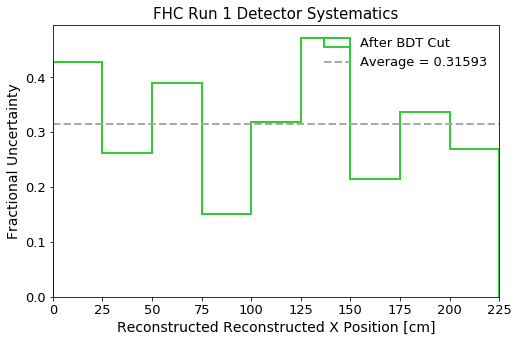

In [79]:
######################
######FHC - ENERGY############
#####################

x_err = [ round(abs(bins[x+1]-bins[x])/2, 3) for x in range(len(bins)-1) ]

plt.figure(figsize=(8, 5))

#cv_bdtcut = 8767.2+5945.0 # GENIE/PPFX weighted number of events for stat uncertainty 
#cv_bdtcut_err = [np.sqrt(x)/x for x in cv_bdtcut]

plt.hist(bin_centers, bins, weights=detsys_dict_comb['fractional_uncertainty'], histtype='step', 
         label='After BDT Cut', color='limegreen', linewidth=2)

plt.hlines(np.average(detsys_dict_comb['fractional_uncertainty']), 0, 250, linestyle='--', color='darkgray', linewidth=2,
           label='Average = '+str(round(np.average(detsys_dict_comb['fractional_uncertainty']), 5)))

plt.xlim(xlow, xhigh)
#plt.ylim(0, 0.7)

plt.legend(fontsize=13,  frameon=False)

plt.xlabel("Reconstructed "+x_label, fontsize=14)
plt.ylabel("Fractional Uncertainty", fontsize=14)

plt.xticks(fontsize=13)
plt.yticks(fontsize=13)

plt.title("FHC Run 1 Detector Systematics", fontsize=15)

#plt.savefig("/uboone/data/users/kmiller/uBNuMI_CCNp/plots/combined/detsys_shr_energy_cali_fhc_frac.pdf", 
#            transparent=True, bbox_inches='tight')

plt.show()

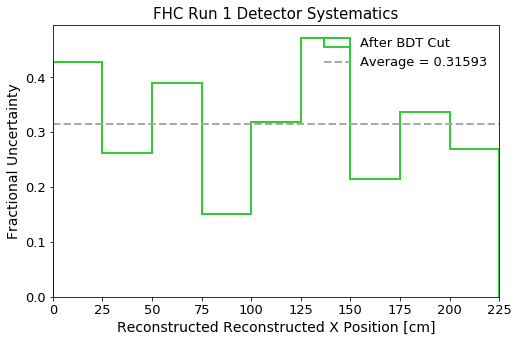

In [80]:
######################
######FHC - ENERGY############
#####################

x_err = [ round(abs(bins[x+1]-bins[x])/2, 3) for x in range(len(bins)-1) ]

plt.figure(figsize=(8, 5))

#cv_bdtcut = 8767.2+5945.0 # GENIE/PPFX weighted number of events for stat uncertainty 
#cv_bdtcut_err = [np.sqrt(x)/x for x in cv_bdtcut]

plt.hist(bin_centers, bins, weights=detsys_dict_comb['fractional_uncertainty'], histtype='step', 
         label='After BDT Cut', color='limegreen', linewidth=2)

plt.hlines(np.average(detsys_dict_comb['fractional_uncertainty']), 0, 250, linestyle='--', color='darkgray', linewidth=2,
           label='Average = '+str(round(np.average(detsys_dict_comb['fractional_uncertainty']), 5)))

plt.xlim(xlow, xhigh)
#plt.ylim(0, 0.7)

plt.legend(fontsize=13,  frameon=False)

plt.xlabel("Reconstructed "+x_label, fontsize=14)
plt.ylabel("Fractional Uncertainty", fontsize=14)

plt.xticks(fontsize=13)
plt.yticks(fontsize=13)

plt.title("FHC Run 1 Detector Systematics", fontsize=15)

#plt.savefig("/uboone/data/users/kmiller/uBNuMI_CCNp/plots/combined/detsys_shr_energy_cali_fhc_frac.pdf", 
#            transparent=True, bbox_inches='tight')

plt.show()

In [31]:
###########################################

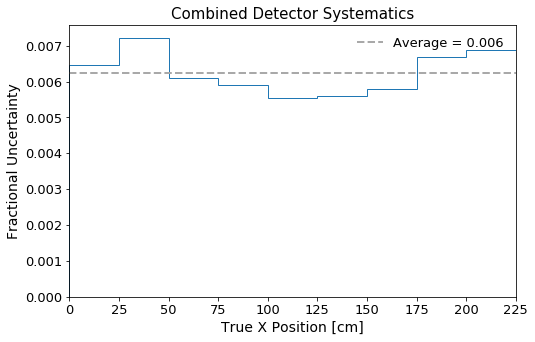

In [30]:
#####################
######COMB - POS############
#####################

if isCombined == True:
    x_err = [ round(abs(bins[x+1]-bins[x])/2, 3) for x in range(len(bins)-1) ]

    plt.figure(figsize=(8, 5))


    plt.hist(bin_centers, bins, weights=detsys_dict_comb['fractional_uncertainty'], histtype='step')

    plt.hlines(np.average(detsys_dict_comb['fractional_uncertainty']), 0, 250, linestyle='--', color='darkgray', linewidth=2,
               label='Average = '+str(round(np.average(detsys_dict_comb['fractional_uncertainty']), 3)))

    plt.xlim(xlow, xhigh)
    #plt.xlim(0, 5)
    #plt.ylim(0.004, 0.009)

    plt.legend(fontsize=13,  frameon=False)

    plt.xlabel(x_label, fontsize=14)
    plt.ylabel("Fractional Uncertainty", fontsize=14)

    plt.xticks(fontsize=13)
    plt.yticks(fontsize=13)

    plt.title("Combined Detector Systematics", fontsize=15)
    
    #plt.savefig("Combined_Nue_Full_Detsys_RecoX.svg", bbox_inches='tight')



# Intrinsic

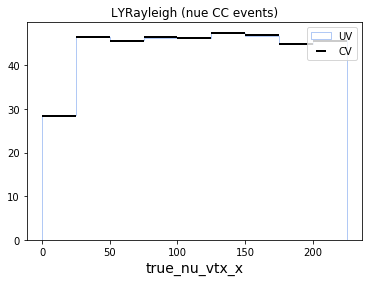

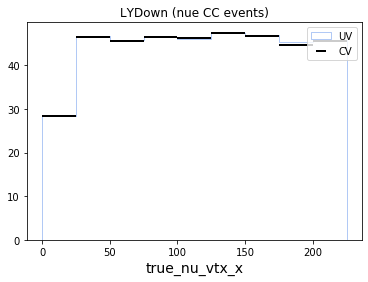

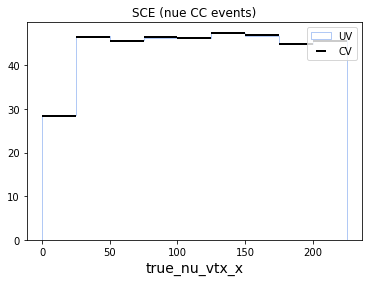

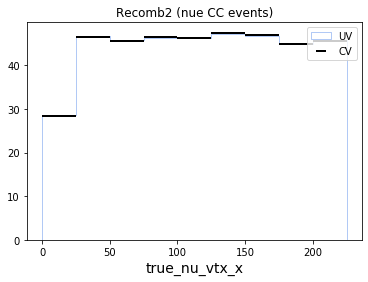

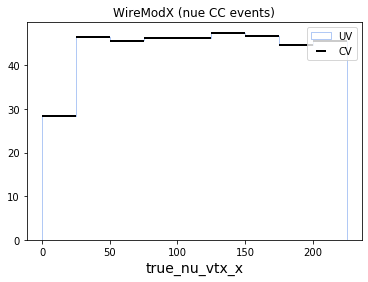

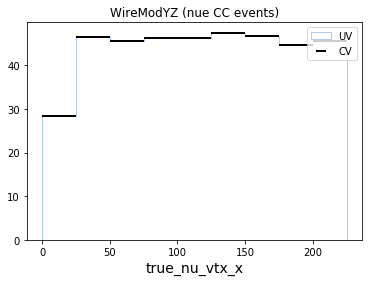

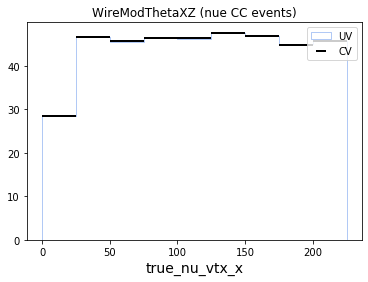

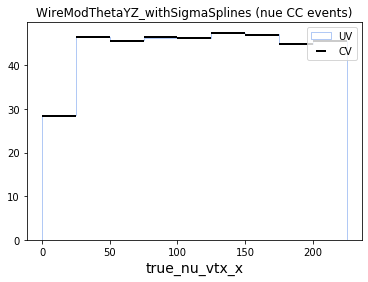

In [31]:
for variation in detvar_run1: 
    
    if variation=='CV': 
        continue
    
    plt.hist(bin_centers, bins, histtype='step', 
                        range=[bins[0], bins[-1]], weights=detvar_dict_run1[variation+'_intrinsic'], 
                        color='cornflowerblue', linewidth=0.5, label='UV')
    
    plt.errorbar(bin_centers, detvar_dict_run1['CV_intrinsic'], xerr=x_err, fmt='none', color='black', linewidth=2, label='CV')
    plt.xlabel(xvar, fontsize=14)
    #plt.ylabel('$\\nu$ / '+str(beamon_pot)+' POT', fontsize=14)
    plt.title(variation+' (nue CC events)')
    plt.legend()
    plt.show()

In [32]:
#Not Bkg subtracting

if isCombined == False:
    detsys_cov_nueCC = {}


    for variation in detvar_run1.keys(): 

        if variation=='CV': 
            continue

        detsys_cov_nueCC[variation+"_to_nueCC"] = calcCov(xvar, bins, detvar_dict_run1['CV_intrinsic'], 
                                                  detvar_dict_run1['CV_intrinsic'], 
                                                  [detvar_dict_run1[variation+'_intrinsic']])
elif isCombined == True:
    detsys_cov_nueCC_run1 = {}
    detsys_cov_nueCC_run3 = {}


    for variation in detvar_run1.keys(): 

        if variation=='CV': 
            continue

        detsys_cov_nueCC_run1[variation+"_to_nueCC"] = calcCov(xvar, bins, detvar_dict_run1['CV_intrinsic'], 
                                                  detvar_dict_run1['CV_intrinsic'], 
                                                  [ detvar_dict_run1[variation+'_intrinsic']])
    
    run1_CV = detvar_dict_run1['CV_intrinsic']
        
    for variation in detvar_run3.keys(): 

        if variation=='CV': 
            continue

        detsys_cov_nueCC_run3[variation+"_to_nueCC"] = calcCov(xvar, bins, detvar_dict_run3['CV_intrinsic'], 
                                                  detvar_dict_run3['CV_intrinsic'], 
                                                  [ detvar_dict_run3[variation+'_intrinsic']])

    run3_CV = detvar_dict_run3['CV_intrinsic']

number of universes =  1
number of universes =  1
number of universes =  1
number of universes =  1
number of universes =  1
number of universes =  1
number of universes =  1
number of universes =  1
number of universes =  1
number of universes =  1
number of universes =  1
number of universes =  1
number of universes =  1
number of universes =  1
number of universes =  1
number of universes =  1
number of universes =  1


In [33]:
# TOTAL cov, corr, fractional uncertainty -- nue CC 


cov = [ [0]*(len(bins)-1) for x in range(len(bins)-1) ]
frac_cov = [ [0]*(len(bins)-1) for x in range(len(bins)-1) ]
cor = [ [0]*(len(bins)-1) for x in range(len(bins)-1) ]

if isCombined == False:
    for i in range(len(bins)-1): 
            for j in range(len(bins)-1):

                cov[i][j] = sum([detsys_cov_nueCC[x+"_to_nueCC"]['cov'][i][j] for x in detvar.keys() if x is not 'CV'])
                frac_cov[i][j] = sum([detsys_cov_nueCC[x+"_to_nueCC"]['frac_cov'][i][j] for x in detvar.keys() if x is not 'CV'])

    for i in range(len(bins)-1): 
        for j in range(len(bins)-1):

            if np.sqrt(cov[i][i])*np.sqrt(cov[j][j]) != 0: 
                    cor[i][j] = cov[i][j] / (np.sqrt(cov[i][i])*np.sqrt(cov[j][j]))

    nueCC_detsys_dict = {
        'cov' : cov, 
        'frac_cov' : frac_cov,
        'cor' : cor,
        'fractional_uncertainty' : np.sqrt(np.diag(frac_cov))
    } 

    nueCC_detsys_dict['fractional_uncertainty']
    
elif isCombined == True:
    
    comb_CV = np.array(run1_CV) + np.array(run3_CV)
    #comb_CV = np.array(run3_CV)
    print(len(run1_CV))
    print(len(comb_CV))
    
    for i in range(len(bins)-1): 
            for j in range(len(bins)-1):

                cov[i][j] = sum([detsys_cov_nueCC_run1[x+"_to_nueCC"]['cov'][i][j] for x in detvar_run1.keys() if x is not 'CV'])
                cov[i][j] += sum([detsys_cov_nueCC_run3[x+"_to_nueCC"]['cov'][i][j] for x in detvar_run3.keys() if x is not 'CV'])
                frac_cov[i][j] = cov[i][j]/(comb_CV[i]*comb_CV[j])
                
    for i in range(len(bins)-1): 
        for j in range(len(bins)-1):

            if np.sqrt(cov[i][i])*np.sqrt(cov[j][j]) != 0: 
                    cor[i][j] = cov[i][j] / (np.sqrt(cov[i][i])*np.sqrt(cov[j][j]))

    nueCC_detsys_dict_comb = {
        'cov' : cov, 
        'frac_cov' : frac_cov,
        'cor' : cor,
        'fractional_uncertainty' : np.sqrt(np.diag(frac_cov))
    } 

    nueCC_detsys_dict_comb['fractional_uncertainty']

9
9


<>:12: SyntaxWarning: "is not" with a literal. Did you mean "!="?
<>:13: SyntaxWarning: "is not" with a literal. Did you mean "!="?
<>:40: SyntaxWarning: "is not" with a literal. Did you mean "!="?
<>:41: SyntaxWarning: "is not" with a literal. Did you mean "!="?
<>:12: SyntaxWarning: "is not" with a literal. Did you mean "!="?
<>:13: SyntaxWarning: "is not" with a literal. Did you mean "!="?
<>:40: SyntaxWarning: "is not" with a literal. Did you mean "!="?
<>:41: SyntaxWarning: "is not" with a literal. Did you mean "!="?
/tmp/ipykernel_11072/2498925777.py:12: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  cov[i][j] = sum([detsys_cov_nueCC[x+"_to_nueCC"]['cov'][i][j] for x in detvar.keys() if x is not 'CV'])
/tmp/ipykernel_11072/2498925777.py:13: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  frac_cov[i][j] = sum([detsys_cov_nueCC[x+"_to_nueCC"]['frac_cov'][i][j] for x in detvar.keys() if x is not 'CV'])
/tmp/ipykernel_11072/2498925777.py:40: SyntaxWarning: 

In [34]:
nueCC_detsys_err = ( np.diag((nueCC_detsys_dict_comb['cov'])))
print(nueCC_detsys_err)

[0.29557553 0.99720038 0.73697911 0.67843375 0.57805696 0.6077474
 0.61518428 0.79935319 0.87610361]


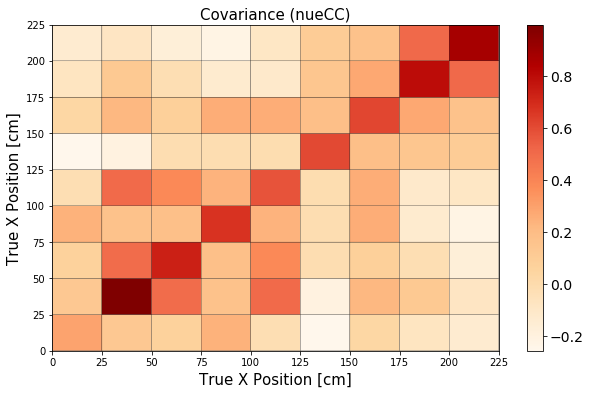

In [35]:
fig = plt.figure(figsize=(10, 6))
        
plt.pcolor(bins, bins, nueCC_detsys_dict_comb['cov'], cmap='OrRd', edgecolors='k')#, vmin=-1, vmax=1)
            
cbar = plt.colorbar()
cbar.ax.tick_params(labelsize=14)


plt.xlabel(x_label, fontsize=15)
plt.ylabel(x_label, fontsize=15)


plt.title('Covariance (nueCC)', fontsize=15)

plt.savefig("IntrinsicOnly_Nue_Full_Detsys_TrueX_Cov.svg", bbox_inches='tight')

plt.show()

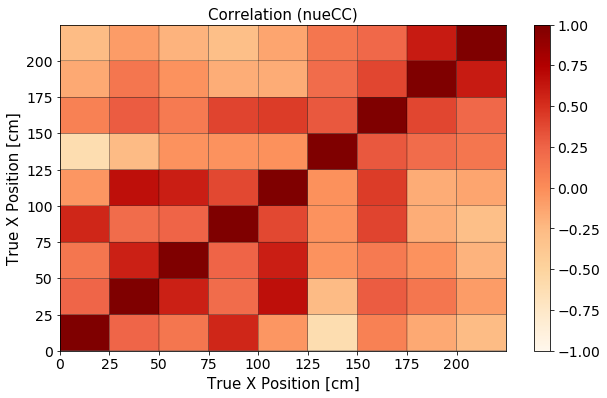

In [36]:
fig = plt.figure(figsize=(10, 6))
        
plt.pcolor(bins, bins, nueCC_detsys_dict_comb['cor'], cmap='OrRd', edgecolors='k', vmin=-1, vmax=1)
            
cbar = plt.colorbar()
cbar.ax.tick_params(labelsize=14)

        
plt.xticks(bins[:-1], fontsize=14)
plt.yticks(bins[:-1], fontsize=14)


plt.xlabel(x_label, fontsize=15)
plt.ylabel(x_label, fontsize=15)

plt.title('Correlation (nueCC)', fontsize=15)

plt.savefig("IntrinsicOnly_Nue_Full_Detsys_TrueX_Cor.svg", bbox_inches='tight')

plt.show()

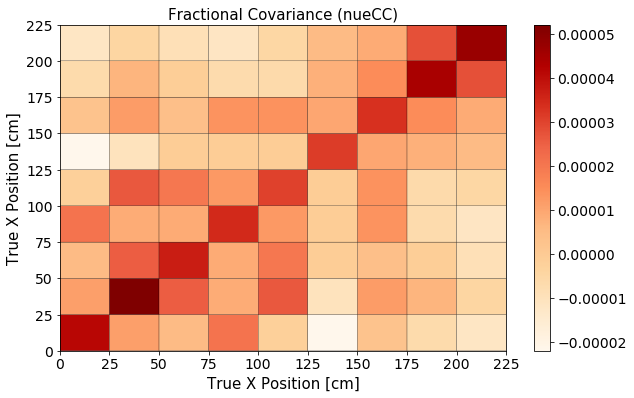

In [37]:
fig = plt.figure(figsize=(10, 6))
        
plt.pcolor(bins, bins, nueCC_detsys_dict_comb['frac_cov'], cmap='OrRd', edgecolors='k')#, vmin=-0.1, vmax=0.1)
            
cbar = plt.colorbar()
cbar.ax.tick_params(labelsize=14)

        
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)


plt.xlabel(x_label, fontsize=15)
plt.ylabel(x_label, fontsize=15)

plt.title('Fractional Covariance (nueCC)', fontsize=15)

plt.savefig("IntrinsicOnly_Nue_Full_Detsys_TrueX_FracCov.svg", bbox_inches='tight')

plt.show()

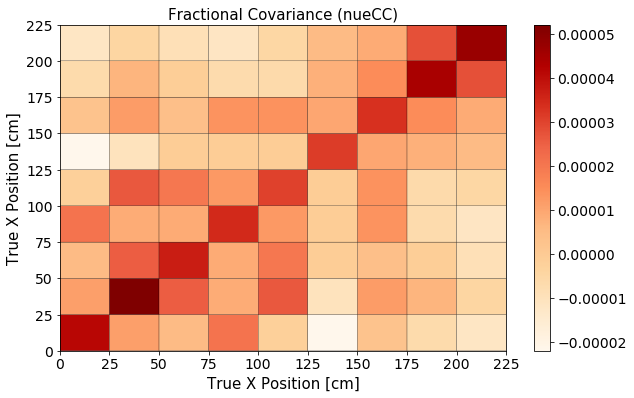

In [38]:
fig = plt.figure(figsize=(10, 6))
        
plt.pcolor(bins, bins, nueCC_detsys_dict_comb['frac_cov'], cmap='OrRd', edgecolors='k')#, vmin=-0.1, vmax=0.1)
            
cbar = plt.colorbar()
cbar.ax.tick_params(labelsize=14)

        
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)


plt.xlabel(x_label, fontsize=15)
plt.ylabel(x_label, fontsize=15)

plt.title('Fractional Covariance (nueCC)', fontsize=15)

plt.show()

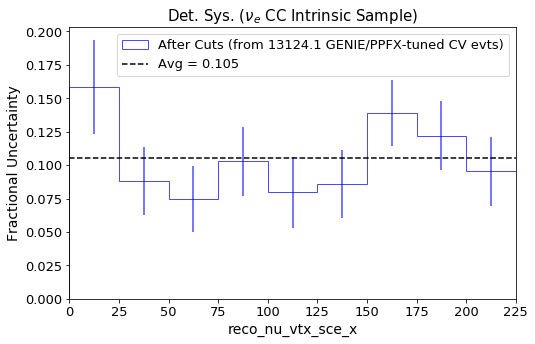

In [69]:
###RUN1
x_err = [ round(abs(bins[x+1]-bins[x])/2, 3) for x in range(len(bins)-1) ]


if isCombined == False:
    cv_cut = plt.hist(df_intrinsic_sel[xvar], bins, range=[bins[0], bins[-1]], 
                weights=df_intrinsic_sel['ppfx_cv']*df_intrinsic_sel['weightSplineTimesTune'])[0]
    plt.close()
elif isCombined == True:
    cv_cut = plt.hist(df_intrinsic_sel_run1[xvar], bins, range=[bins[0], bins[-1]], 
                weights=df_intrinsic_sel_run1['ppfx_cv']*df_intrinsic_sel_run1['weightSplineTimesTune'])[0]
    plt.close()
    cv_cut += plt.hist(df_intrinsic_sel_run3[xvar], bins, range=[bins[0], bins[-1]], 
                weights=df_intrinsic_sel_run3['ppfx_cv']*df_intrinsic_sel_run3['weightSplineTimesTune'])[0]
    plt.close()

cv_cut_err = [np.sqrt(x)/x for x in cv_cut]

plt.figure(figsize=(8, 5))

if isCombined == False:
    plt.errorbar(bin_centers, nueCC_detsys_dict['fractional_uncertainty'], fmt='none', 
                 yerr=cv_cut_err, 
                 color='blue', alpha=0.7)

    plt.hist(bin_centers, bins, weights=nueCC_detsys_dict['fractional_uncertainty'], histtype='step', 
             label='After Cuts (from '+str(round(sum(cv_cut),1))+' GENIE/PPFX-tuned CV evts)', color='blue',alpha=0.7)

    plt.hlines(np.average(nueCC_detsys_dict['fractional_uncertainty']), bins[0], bins[-1], linestyle='--', 
               label='Avg = '+str(round(np.average(nueCC_detsys_dict['fractional_uncertainty']), 3)))
elif isCombined == True:
    plt.errorbar(bin_centers, nueCC_detsys_dict_comb['fractional_uncertainty'], fmt='none', 
                 yerr=cv_cut_err, 
                 color='blue', alpha=0.7)

    plt.hist(bin_centers, bins, weights=nueCC_detsys_dict_comb['fractional_uncertainty'], histtype='step', 
             label='After Cuts (from '+str(round(sum(cv_cut),1))+' GENIE/PPFX-tuned CV evts)', color='blue',alpha=0.7)

    plt.hlines(np.average(nueCC_detsys_dict_comb['fractional_uncertainty']), bins[0], bins[-1], linestyle='--', 
               label='Avg = '+str(round(np.average(nueCC_detsys_dict_comb['fractional_uncertainty']), 3)))

    
plt.xlim(bins[0], bins[-1])
#plt.ylim(0, 0.4)

plt.legend(fontsize=13)

plt.xlabel(xvar, fontsize=14)
plt.ylabel("Fractional Uncertainty", fontsize=14)

plt.xticks(fontsize=13)
plt.yticks(fontsize=13)

plt.title("Det. Sys. ($\\nu_{e}$ CC Intrinsic Sample)", fontsize=15)
#plt.savefig(parameters(ISRUN3)['plots_path']+"RHCRUN3DetSys.pdf", transparent=True, bbox_inches='tight') 

plt.show()

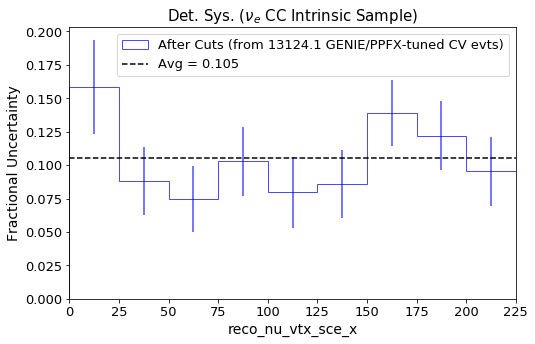

In [70]:
#####RUN3
x_err = [ round(abs(bins[x+1]-bins[x])/2, 3) for x in range(len(bins)-1) ]


if isCombined == False:
    cv_cut = plt.hist(df_intrinsic_sel[xvar], bins, range=[bins[0], bins[-1]], 
                weights=df_intrinsic_sel['ppfx_cv']*df_intrinsic_sel['weightSplineTimesTune'])[0]
    plt.close()
elif isCombined == True:
    cv_cut = plt.hist(df_intrinsic_sel_run1[xvar], bins, range=[bins[0], bins[-1]], 
                weights=df_intrinsic_sel_run1['ppfx_cv']*df_intrinsic_sel_run1['weightSplineTimesTune'])[0]
    plt.close()
    cv_cut += plt.hist(df_intrinsic_sel_run3[xvar], bins, range=[bins[0], bins[-1]], 
                weights=df_intrinsic_sel_run3['ppfx_cv']*df_intrinsic_sel_run3['weightSplineTimesTune'])[0]
    plt.close()

cv_cut_err = [np.sqrt(x)/x for x in cv_cut]

plt.figure(figsize=(8, 5))

if isCombined == False:
    plt.errorbar(bin_centers, nueCC_detsys_dict['fractional_uncertainty'], fmt='none', 
                 yerr=cv_cut_err, 
                 color='blue', alpha=0.7)

    plt.hist(bin_centers, bins, weights=nueCC_detsys_dict['fractional_uncertainty'], histtype='step', 
             label='After Cuts (from '+str(round(sum(cv_cut),1))+' GENIE/PPFX-tuned CV evts)', color='blue',alpha=0.7)

    plt.hlines(np.average(nueCC_detsys_dict['fractional_uncertainty']), bins[0], bins[-1], linestyle='--', 
               label='Avg = '+str(round(np.average(nueCC_detsys_dict['fractional_uncertainty']), 3)))
elif isCombined == True:
    plt.errorbar(bin_centers, nueCC_detsys_dict_comb['fractional_uncertainty'], fmt='none', 
                 yerr=cv_cut_err, 
                 color='blue', alpha=0.7)

    plt.hist(bin_centers, bins, weights=nueCC_detsys_dict_comb['fractional_uncertainty'], histtype='step', 
             label='After Cuts (from '+str(round(sum(cv_cut),1))+' GENIE/PPFX-tuned CV evts)', color='blue',alpha=0.7)

    plt.hlines(np.average(nueCC_detsys_dict_comb['fractional_uncertainty']), bins[0], bins[-1], linestyle='--', 
               label='Avg = '+str(round(np.average(nueCC_detsys_dict_comb['fractional_uncertainty']), 3)))

    
plt.xlim(bins[0], bins[-1])
#plt.ylim(0, 0.4)

plt.legend(fontsize=13)

plt.xlabel(xvar, fontsize=14)
plt.ylabel("Fractional Uncertainty", fontsize=14)

plt.xticks(fontsize=13)
plt.yticks(fontsize=13)

plt.title("Det. Sys. ($\\nu_{e}$ CC Intrinsic Sample)", fontsize=15)
#plt.savefig(parameters(ISRUN3)['plots_path']+"RHCRUN3DetSys.pdf", transparent=True, bbox_inches='tight') 

plt.show()

[457.2381897  829.18322754 869.64648438 856.66992188 732.15307617
 848.01098633 875.87646484 837.86669922 870.35107422]

[ 853.96435547 1554.4453125  1653.64782715 1555.10021973 1466.65551758
 1547.09155273 1673.14208984 1564.20214844 1573.93115234]
[0.03422000969188676, 0.025363680637938167, 0.024591130114906063, 0.025358339307921855, 0.0261117476397432, 0.02542388951681368, 0.02444745119070664, 0.025284452904616242, 0.025206185865726323]



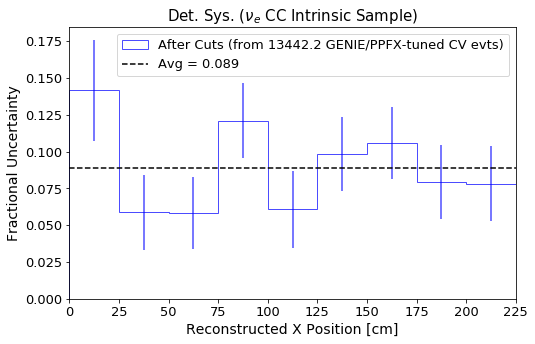

In [64]:
######BOTH
x_err = [ round(abs(bins[x+1]-bins[x])/2, 3) for x in range(len(bins)-1) ]


if isCombined == False:
    cv_cut = plt.hist(df_intrinsic_sel[xvar], bins, range=[bins[0], bins[-1]], 
                weights=df_intrinsic_sel['ppfx_cv']*df_intrinsic_sel['weightSplineTimesTune'])[0]
    plt.close()
elif isCombined == True:
    cv_cut = plt.hist(df_intrinsic_sel_run1[xvar], bins, range=[bins[0], bins[-1]], 
                weights=df_intrinsic_sel_run1['ppfx_cv']*df_intrinsic_sel_run1['weightSplineTimesTune'])[0]
    print(cv_cut)
    print("")
    plt.close()
    cv_cut += plt.hist(df_intrinsic_sel_run3[xvar], bins, range=[bins[0], bins[-1]], 
                weights=df_intrinsic_sel_run3['ppfx_cv']*df_intrinsic_sel_run3['weightSplineTimesTune'])[0]
    print(cv_cut)
    plt.close()
    
    np.savetxt("cv_cut_R1R3_nue_Sept19.csv", 
               cv_cut,
               delimiter =", ", 
               fmt ='% s')

cv_cut_err = [np.sqrt(x)/x for x in cv_cut]
print(cv_cut_err )
print("")

plt.figure(figsize=(8, 5))

if isCombined == False:
    plt.errorbar(bin_centers, nueCC_detsys_dict['fractional_uncertainty'], fmt='none', 
                 yerr=cv_cut_err, 
                 color='blue', alpha=0.7)

    plt.hist(bin_centers, bins, weights=nueCC_detsys_dict['fractional_uncertainty'], histtype='step', 
             label='After Cuts (from '+str(round(sum(cv_cut),1))+' GENIE/PPFX-tuned CV evts)', color='blue',alpha=0.7)

    plt.hlines(np.average(nueCC_detsys_dict['fractional_uncertainty']), bins[0], bins[-1], linestyle='--', 
               label='Avg = '+str(round(np.average(nueCC_detsys_dict['fractional_uncertainty']), 3)))
elif isCombined == True:
    plt.errorbar(bin_centers, nueCC_detsys_dict_comb['fractional_uncertainty'], fmt='none', 
                 yerr=cv_cut_err, 
                 color='blue', alpha=0.7)

    plt.hist(bin_centers, bins, weights=nueCC_detsys_dict_comb['fractional_uncertainty'], histtype='step', 
             label='After Cuts (from '+str(round(sum(cv_cut),1))+' GENIE/PPFX-tuned CV evts)', color='blue',alpha=0.7)

    plt.hlines(np.average(nueCC_detsys_dict_comb['fractional_uncertainty']), bins[0], bins[-1], linestyle='--', 
               label='Avg = '+str(round(np.average(nueCC_detsys_dict_comb['fractional_uncertainty']), 3)))

    
plt.xlim(bins[0], bins[-1])
#plt.ylim(0, 0.4)

plt.legend(fontsize=13)

plt.xlabel(x_label, fontsize=14)
plt.ylabel("Fractional Uncertainty", fontsize=14)

plt.xticks(fontsize=13)
plt.yticks(fontsize=13)

plt.title("Det. Sys. ($\\nu_{e}$ CC Intrinsic Sample)", fontsize=15)

#plt.savefig("IntrinsicOnly_Nue_Full_Detsys_RecoX.svg", bbox_inches='tight')

plt.show()

## Note

After running Run1 FHC, simsilar results are produced to Katrina Miller's analysis and the same effect is found. This is unsurprising, given it uses her selection. Therefore the results of her study can be used, and there's no need to repeat it. 

## Note

Her binning is a bit different, but can use same principle and use 8.3%. No change if category used or not.

### Note

With full Katrina signal def and as above it produces 8.3% still

8.9% if go to 225 only.

When using Sept19 Truth, 0.6%

10.5% reco with bkg subtracted